https://www.geeksforgeeks.org/bitcoin-price-prediction-using-machine-learning-in-python/

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
import sqlite3

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn import metrics

import warnings
warnings.filterwarnings('ignore')

# 데이터베이스 파일 경로
db_file = '../btc_data_day_20170901_20241205.db'

# 데이터베이스 연결
con = sqlite3.connect(db_file)

# SQL 쿼리 실행 및 데이터프레임으로 불러오기
query = "SELECT * FROM ticker_data"
df = pd.read_sql_query(query, con)

# 데이터베이스 연결 종료
con.close()


df = df.drop_duplicates(keep='first')
df['datetime'] = pd.to_datetime(df['trade_date'] + ' ' + df['trade_time'])
df = df.sort_values(by='datetime')
df.rename(columns={'trade_price':'closing_price'}, inplace=True)
new_column_order = [
    'datetime', 'type', 'code', 'opening_price', 'closing_price', 'high_price', 'low_price', 'trade_volume', 'trade_date'
]
df = df[new_column_order] 
df = df[df['trade_date']!='2017-09-26']
df = df[df['trade_date']!='2017-09-25']
df['year'] = df['datetime'].dt.year
df['month'] = df['datetime'].dt.month
df['day'] = df['datetime'].dt.day
df['open-close']  = df['opening_price'] - df['closing_price']
df['low-high']  = df['low_price'] - df['high_price']
df['target'] = np.where(df['closing_price'].shift(-1) > df['closing_price'], 1, 0)
df['is_quarter_end'] = np.where(df['month']%3==0,1,0)
df.reset_index(drop=True, inplace=True)
df

,datetime,type,code,opening_price,closing_price,high_price,low_price,trade_volume,trade_date,year,month,day,open-close,low-high,target,is_quarter_end
0,2017-09-27 09:00:00,ticker,KRW-BTC,4322000.0,4657000.0,4677000.0,4318000.0,32.269662,2017-09-27,2017,9,27,-335000.0,-359000.0,0,1
1,2017-09-28 09:00:00,ticker,KRW-BTC,4657000.0,4586000.0,4772000.0,4519000.0,80.588243,2017-09-28,2017,9,28,71000.0,-253000.0,1,1
2,2017-09-29 09:00:00,ticker,KRW-BTC,4586000.0,4657000.0,4709000.0,4476000.0,59.352373,2017-09-29,2017,9,29,-71000.0,-233000.0,1,1
3,2017-09-30 09:00:00,ticker,KRW-BTC,4657000.0,4895000.0,4896000.0,4651000.0,19.998483,2017-09-30,2017,9,30,-238000.0,-245000.0,1,1
4,2017-10-01 09:00:00,ticker,KRW-BTC,4889000.0,4962000.0,4978000.0,4682000.0,27.323332,2017-10-01,2017,10,1,-73000.0,-296000.0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2621,2024-11-30 09:00:00,ticker,KRW-BTC,134542000.0,133701000.0,134809000.0,133600000.0,2374.866974,2024-11-30,2024,11,30,841000.0,-1209000.0,1,0
2622,2024-12-01 09:00:00,ticker,KRW-BTC,133722000.0,133802000.0,135199000.0,133297000.0,2835.146498,2024-12-01,2024,12,1,-80000.0,-1902000.0,0,1
2623,2024-12-02 09:00:00,ticker,KRW-BTC,133802000.0,133535000.0,135800000.0,132260000.0,5356.774825,2024-12-02,2024,12,2,267000.0,-3540000.0,1,1
2624,2024-12-03 09:00:00,ticker,KRW-BTC,133523000.0,133700000.0,134680000.0,88266000.0,18097.084256,2024-12-03,2024,12,3,-177000.0,-46414000.0,1,1


In [2]:
df.shape

(2626, 16)

In [3]:
df.describe()

,datetime,opening_price,closing_price,high_price,low_price,trade_volume,year,month,day,open-close,low-high,target,is_quarter_end
count,2626,2.626000e+03,2.626000e+03,2.626000e+03,2.626000e+03,2626.000000,2626.000000,2626.000000,2626.000000,2.626000e+03,2.626000e+03,2626.000000,2626.000000
mean,2021-05-01 21:00:00.000000256,3.426083e+07,3.431189e+07,3.497464e+07,3.350870e+07,7692.042908,2020.823686,6.626809,15.730769,-5.106321e+04,-1.465944e+06,0.520183,0.328256
min,2017-09-27 09:00:00,3.620000e+06,3.619000e+06,3.685000e+06,3.562000e+06,3.352825,2017.000000,1.000000,1.000000,-1.306300e+07,-4.641400e+07,0.000000,0.000000
25%,2019-07-15 15:00:00,9.989500e+06,9.993750e+06,1.025825e+07,9.788750e+06,3101.850556,2019.000000,4.000000,8.000000,-3.132500e+05,-2.024500e+06,0.000000,0.000000
50%,2021-05-01 21:00:00,2.760200e+07,2.760050e+07,2.804300e+07,2.719050e+07,5195.658268,2021.000000,7.000000,16.000000,-9.000000e+03,-8.395000e+05,1.000000,0.000000
75%,2023-02-17 03:00:00,5.145650e+07,5.152700e+07,5.238725e+07,5.031150e+07,8884.678944,2023.000000,10.000000,23.000000,2.630000e+05,-3.600000e+05,1.000000,1.000000
max,2024-12-04 09:00:00,1.370500e+08,1.387600e+08,1.399200e+08,1.341950e+08,101681.962251,2024.000000,12.000000,31.000000,8.231000e+06,-2.400000e+04,1.000000,1.000000
std,NaN,2.845204e+07,2.851854e+07,2.898625e+07,2.789873e+07,8366.647064,2.087730,3.464447,8.818523,1.256231e+06,1.830705e+06,0.499688,0.469668


In [55]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2626 entries, 0 to 2625
Data columns (total 16 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   datetime        2626 non-null   datetime64[ns]
 1   type            2626 non-null   object        
 2   code            2626 non-null   object        
 3   opening_price   2626 non-null   float64       
 4   closing_price   2626 non-null   float64       
 5   high_price      2626 non-null   float64       
 6   low_price       2626 non-null   float64       
 7   trade_volume    2626 non-null   float64       
 8   trade_date      2626 non-null   object        
 9   year            2626 non-null   int32         
 10  month           2626 non-null   int32         
 11  day             2626 non-null   int32         
 12  open-close      2626 non-null   float64       
 13  low-high        2626 non-null   float64       
 14  target          2626 non-null   int32         
 15  is_q

### 종가 시계열

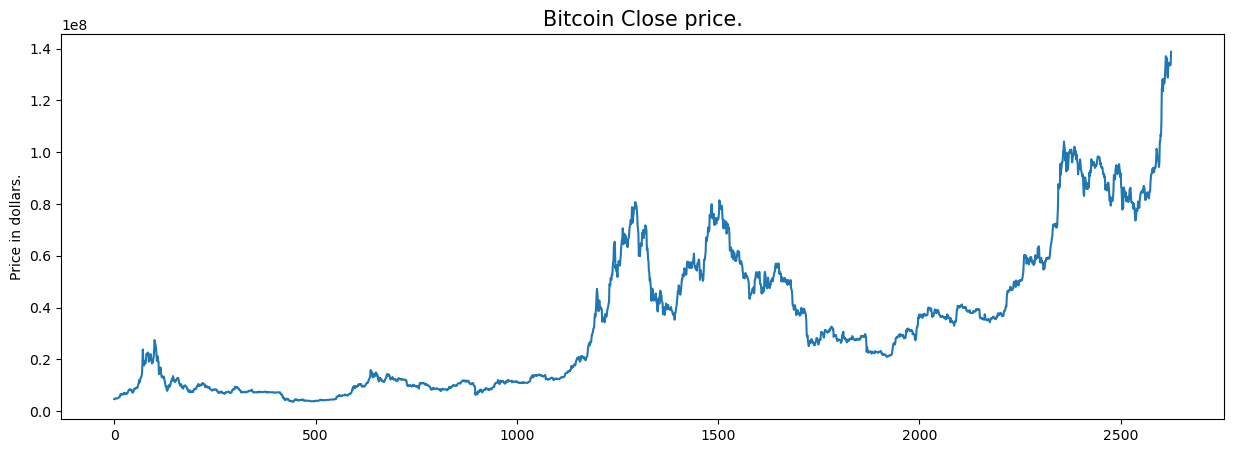

In [56]:
plt.figure(figsize=(15, 5))
plt.plot(df['closing_price'])
plt.title('Bitcoin Close price.', fontsize=15)
plt.ylabel('Price in dollars.')
plt.show()

### 시가, 종가, 최고가, 최저가 분포

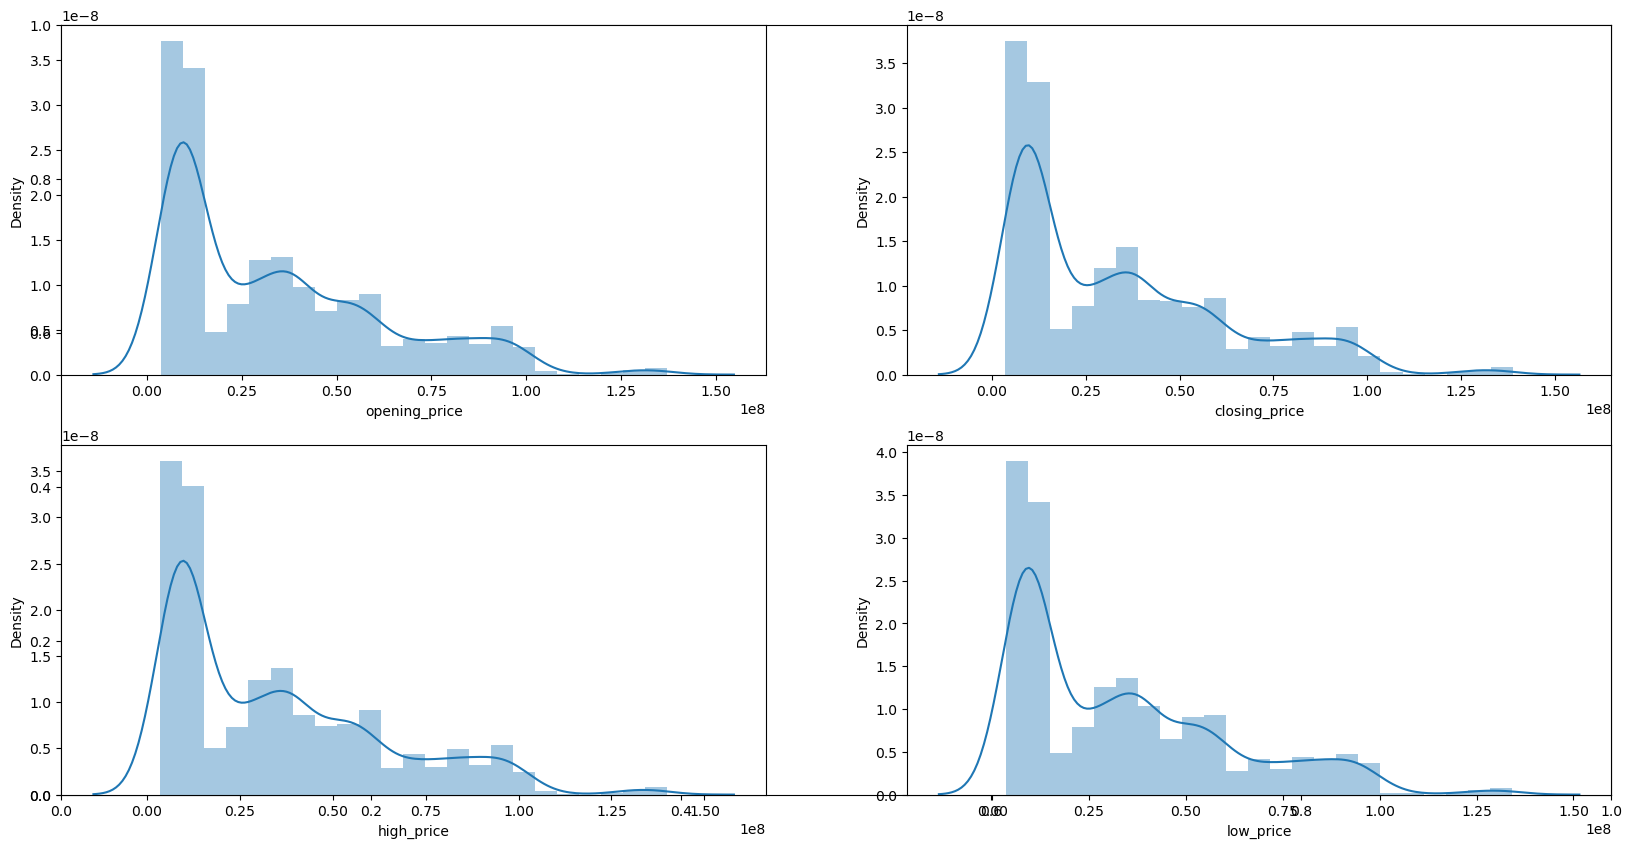

In [57]:
features = ['opening_price', 'closing_price', 'high_price', 'low_price']

plt.subplots(figsize=(20,10))
for i, col in enumerate(features):
  plt.subplot(2,2,i+1)
  sb.distplot(df[col])
plt.show()

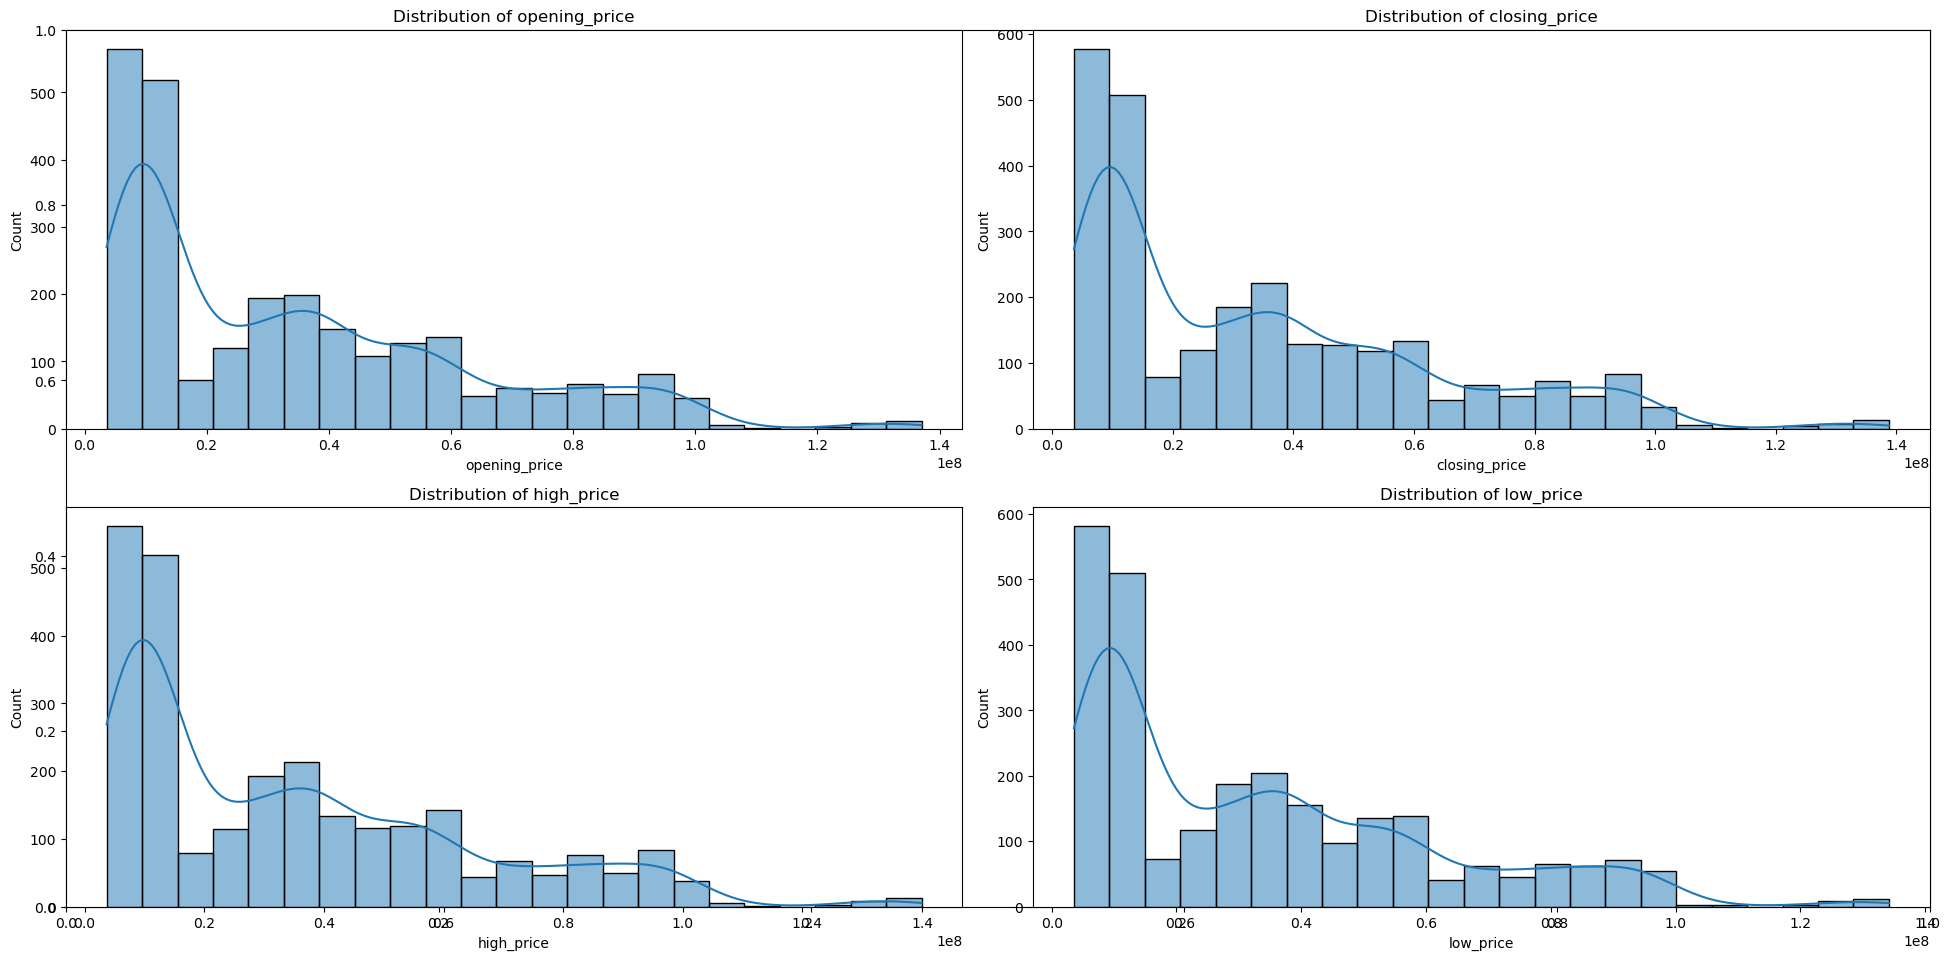

In [4]:
features = ['opening_price', 'closing_price', 'high_price', 'low_price']

plt.subplots(figsize=(20, 10))
for i, col in enumerate(features):
    plt.subplot(2, 2, i + 1)
    sb.histplot(df[col], kde=True)  # kde=True로 커널 밀도 추정 추가
    plt.title(f'Distribution of {col}')  # 각 서브플롯에 제목 추가
    plt.xlabel(col)  # x축 레이블 추가


plt.tight_layout()  # 서브플롯 간의 간격 조정
plt.show()


### 박스 플롯으로 이상치 판별

opening_price의 이상치 개수: 23
closing_price의 이상치 개수: 24
high_price의 이상치 개수: 24
low_price의 이상치 개수: 23


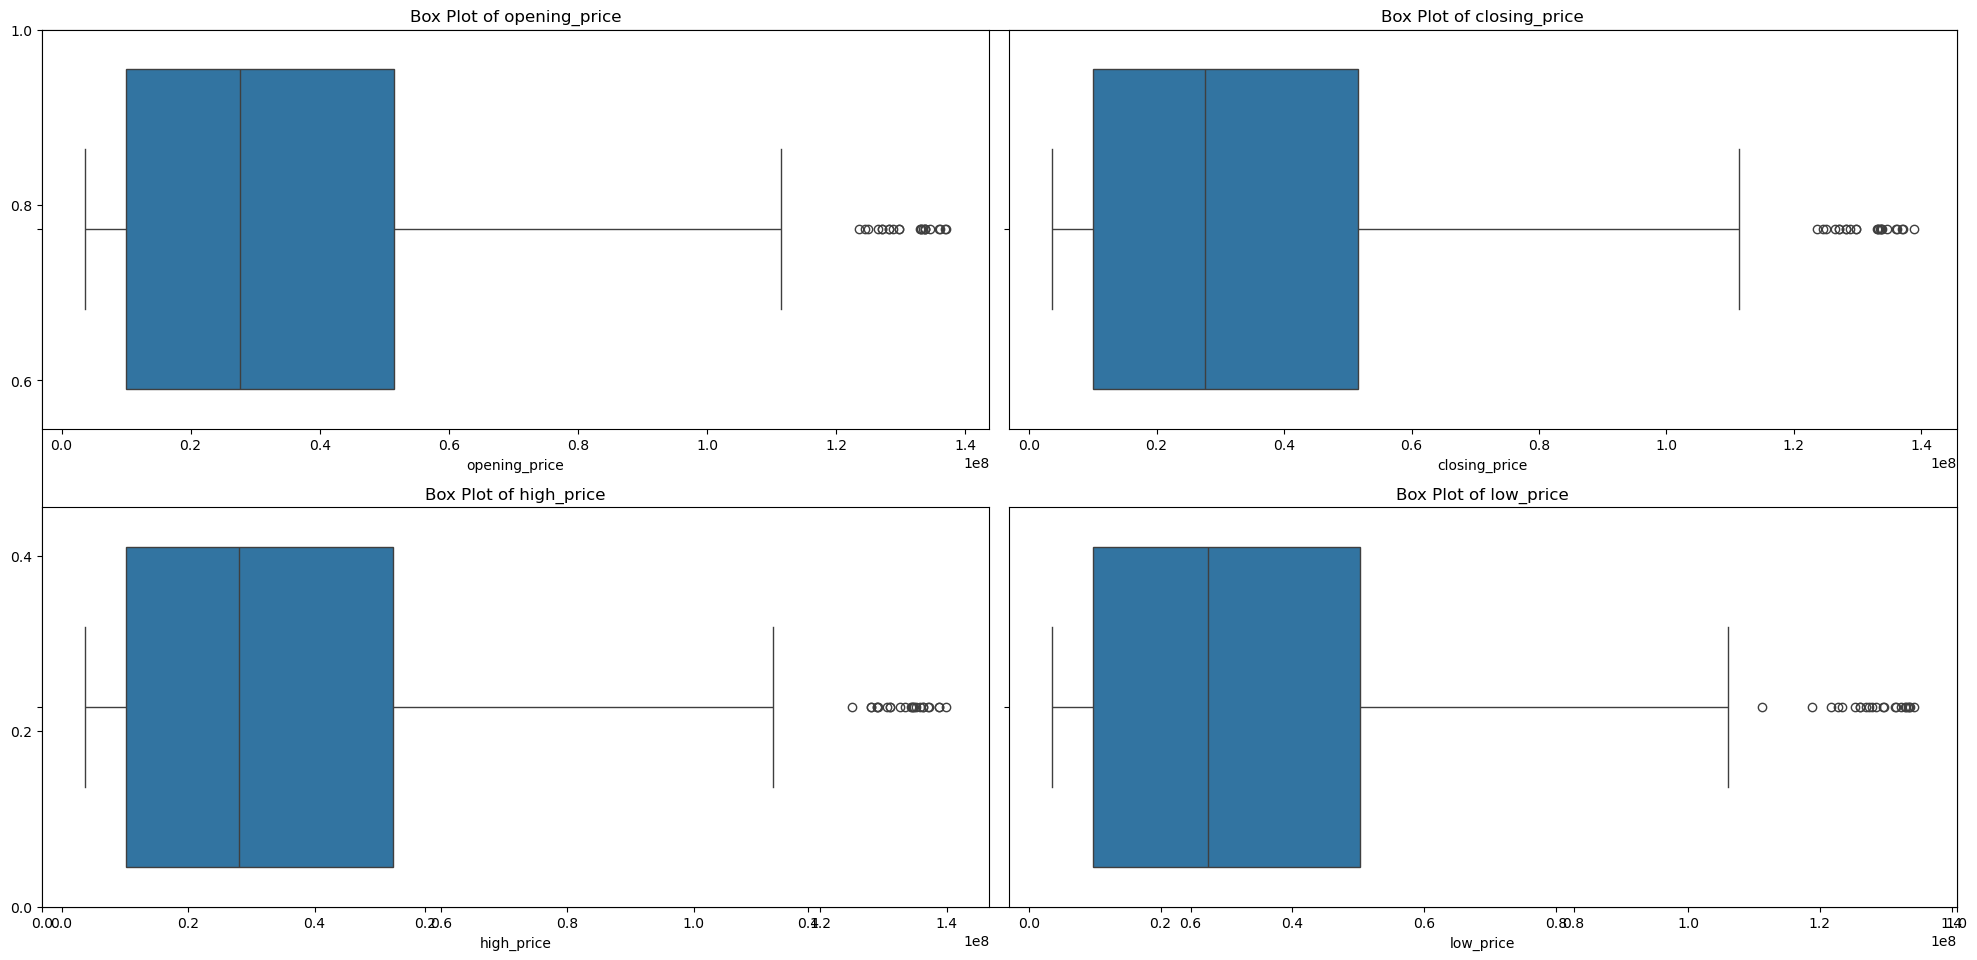

In [59]:
features = ['opening_price', 'closing_price', 'high_price', 'low_price']

plt.subplots(figsize=(20, 10))

for i, col in enumerate(features):
    plt.subplot(2, 2, i + 1)
    sb.boxplot(x=df[col])  # x 매개변수를 사용하여 세로로 표시
    plt.title(f'Box Plot of {col}')  # 각 서브플롯에 제목 추가
    plt.xlabel(col)  # x축 레이블 추가

    # 이상치 개수 계산
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    # 이상치 개수
    outliers_count = df[(df[col] < lower_bound) | (df[col] > upper_bound)].shape[0]
    print(f'{col}의 이상치 개수: {outliers_count}')

plt.tight_layout()  # 서브플롯 간의 간격 조정
plt.show()

### 각 컬럼의 값들중 특정 연도에서 튀기 때문에 이상치가 존재

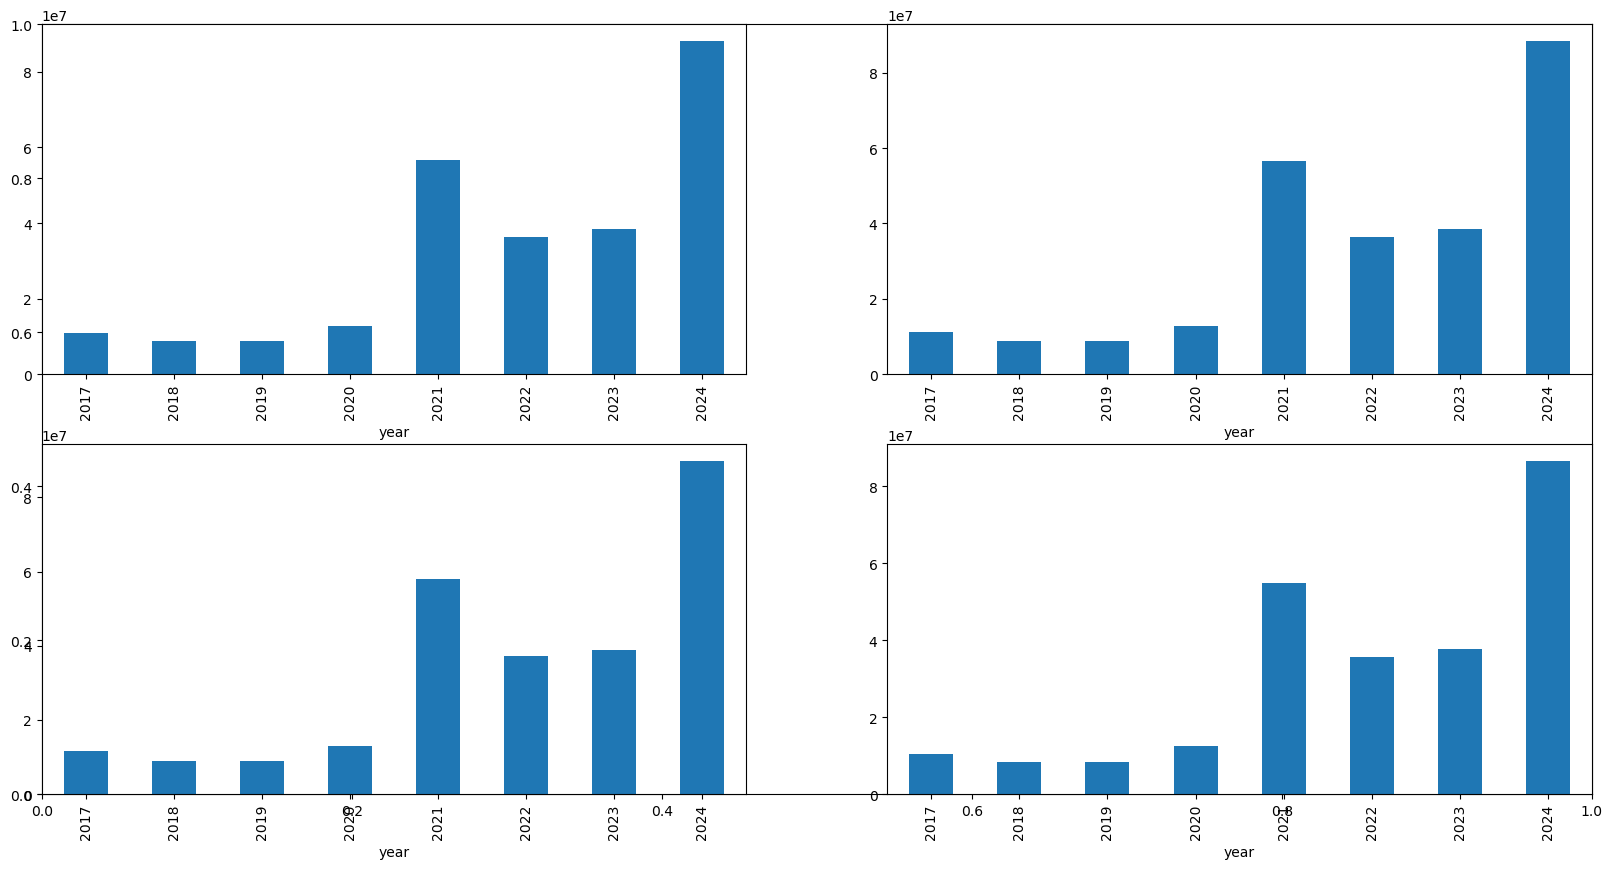

In [60]:
data_grouped = df.groupby('year')[['opening_price', 'closing_price', 'high_price', 'low_price']].mean()
plt.subplots(figsize=(20,10))
for i, col in enumerate(['opening_price', 'closing_price', 'high_price', 'low_price']):
  plt.subplot(2,2,i+1)
  data_grouped[col].plot.bar()
plt.show()

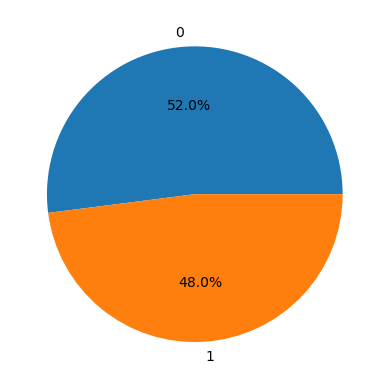

In [61]:
plt.pie(df['target'].value_counts().values, 
        labels=[0, 1], autopct='%1.1f%%')
plt.show()

### OHLC 사이에 높은 상관관계가 있는 것을 알 수 있는데, 이는 매우 명백한 사실이며, 추가된 기능은 서로 또는 이전에 제공된 기능과 높은 상관관계가 없으므로 모델을 구축하기에 적합하다는 것을 의미

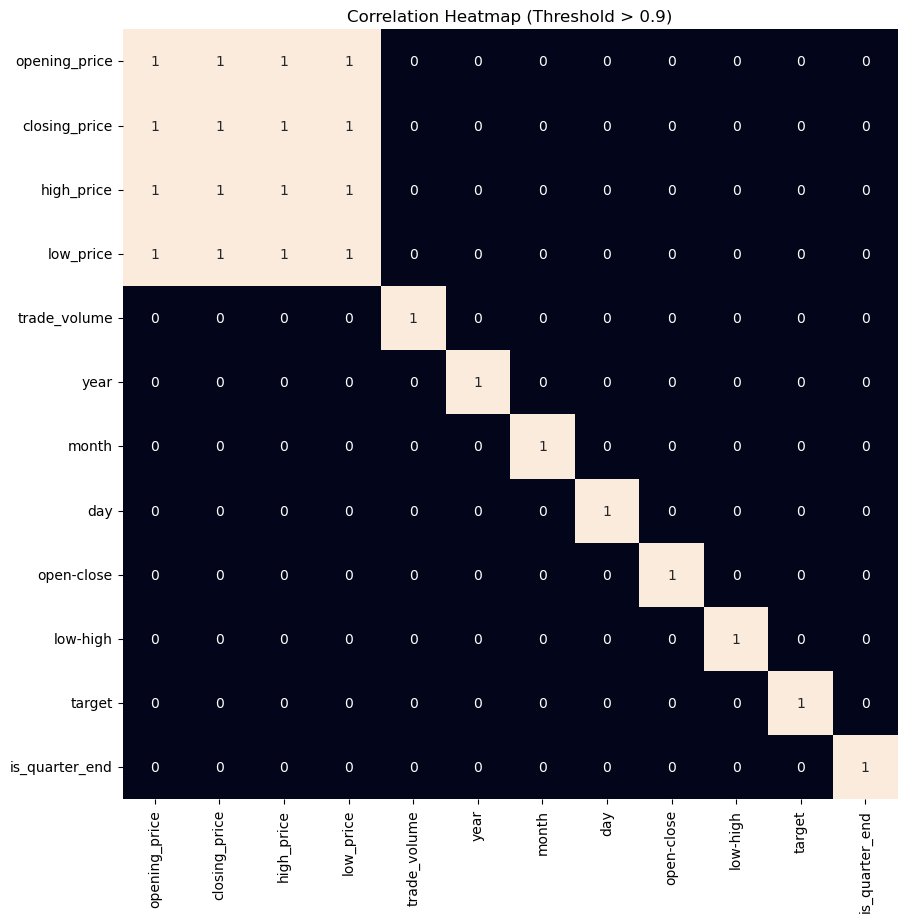

In [62]:
numeric_df = df.select_dtypes(include=[np.number])

# 상관관계 계산
correlation_matrix = numeric_df.corr()

# 히트맵 시각화
plt.figure(figsize=(10, 10))
sb.heatmap(correlation_matrix > 0.9, annot=True, cbar=False, fmt='d')  # fmt='d'로 정수 형태로 표시
plt.title('Correlation Heatmap (Threshold > 0.9)')
plt.show()

In [63]:
features = df[['open-close', 'low-high', 'is_quarter_end']]
target = df['target']

scaler = StandardScaler()
features = scaler.fit_transform(features)

X_train, X_valid, Y_train, Y_valid = train_test_split(
    features, target, test_size=0.1, random_state=2022)
print(X_train.shape, X_valid.shape)

(2363, 3) (263, 3)


### 모델 학습 및 평가

In [64]:
models = [LogisticRegression(), SVC(kernel='poly', probability=True), XGBClassifier()]

for i in range(3):
  models[i].fit(X_train, Y_train)

  print(f'{models[i]} : ')
  print('Training Accuracy : ', metrics.roc_auc_score(Y_train, models[i].predict_proba(X_train)[:,1]))
  print('Validation Accuracy : ', metrics.roc_auc_score(Y_valid, models[i].predict_proba(X_valid)[:,1]))
  print()

LogisticRegression() : 
Training Accuracy :  0.5124258181525994
Validation Accuracy :  0.4748201438848921

SVC(kernel='poly', probability=True) : 
Training Accuracy :  0.4951301123776072
Validation Accuracy :  0.4631004873520539

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...) : 
Training 

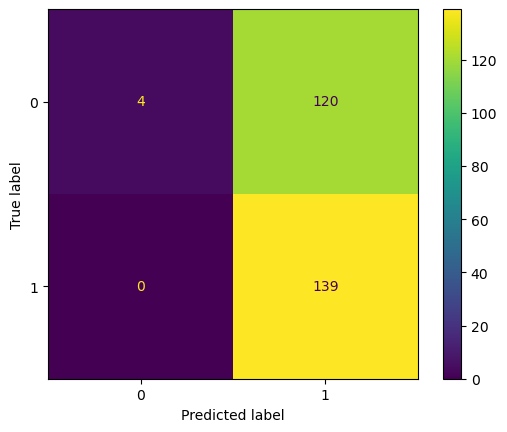

In [65]:
from sklearn.metrics import ConfusionMatrixDisplay

ConfusionMatrixDisplay.from_estimator(models[0], X_valid, Y_valid)
plt.show()

In [66]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
import sqlite3

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn import metrics

import warnings
warnings.filterwarnings('ignore')

# 데이터베이스 파일 경로
db_file = '../btc_data_day_20170901_20241205.db'

# 데이터베이스 연결
con = sqlite3.connect(db_file)

# SQL 쿼리 실행 및 데이터프레임으로 불러오기
query = "SELECT * FROM ticker_data"
df = pd.read_sql_query(query, con)

# 데이터베이스 연결 종료
con.close()


df = df.drop_duplicates(keep='first')
df['datetime'] = pd.to_datetime(df['trade_date'] + ' ' + df['trade_time'])
df = df.sort_values(by='datetime')
df.rename(columns={'trade_price':'closing_price'}, inplace=True)
new_column_order = [
    'datetime', 'type', 'code', 'opening_price', 'closing_price', 'high_price', 'low_price', 'trade_volume', 'trade_date'
]
df = df[new_column_order] 
df = df[df['trade_date']!='2017-09-26']
df = df[df['trade_date']!='2017-09-25']
df['year'] = df['datetime'].dt.year
df['month'] = df['datetime'].dt.month
df['day'] = df['datetime'].dt.day
df['open-close']  = df['opening_price'] - df['closing_price']
df['low-high']  = df['low_price'] - df['high_price']
df['target'] = np.where(df['closing_price'].shift(-1) > df['closing_price'], 1, 0)
df['is_quarter_end'] = np.where(df['month']%3==0,1,0)
df.reset_index(drop=True, inplace=True)

df_all = df[df['trade_date'].str[:4] != '2024']
df2024 = df[df['trade_date'].str[:4] == '2024']

features = df_all[['open-close', 'low-high', 'is_quarter_end']]
target = df_all['target']

features_2024 = df2024[['open-close', 'low-high', 'is_quarter_end']]
target_2024 = df2024['target']

scaler = StandardScaler()
features = scaler.fit_transform(features)
features_2024 = scaler.transform(features_2024)

X_train, X_valid, Y_train, Y_valid = train_test_split(
    features, target, test_size=0.1, random_state=11)

models = [LogisticRegression(), SVC(kernel='poly', probability=True), XGBClassifier()]

for i in range(3):
  models[i].fit(X_train, Y_train)

  print(f'{models[i]} : ')
  print('Training Accuracy : ', metrics.roc_auc_score(Y_train, models[i].predict_proba(X_train)[:,1]))
  print('Test Accuracy : ', metrics.roc_auc_score(Y_valid, models[i].predict_proba(X_valid)[:,1]))
  print()

for i in range(3):
  print(f'{models[i]} : ')
  print('Validation Accuracy : ', metrics.roc_auc_score(target_2024, models[i].predict_proba(features_2024)[:,1]))
  print()

LogisticRegression() : 
Training Accuracy :  0.5031040744523891
Test Accuracy :  0.4862877278994944

SVC(kernel='poly', probability=True) : 
Training Accuracy :  0.48533934854159566
Test Accuracy :  0.46001225677953117

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...) : 
Training Accuracy :

혼동 행렬:
[[ 26 137]
 [ 27 149]]
True Positive (TP): 149
True Negative (TN): 26
False Positive (FP): 137
False Negative (FN): 27


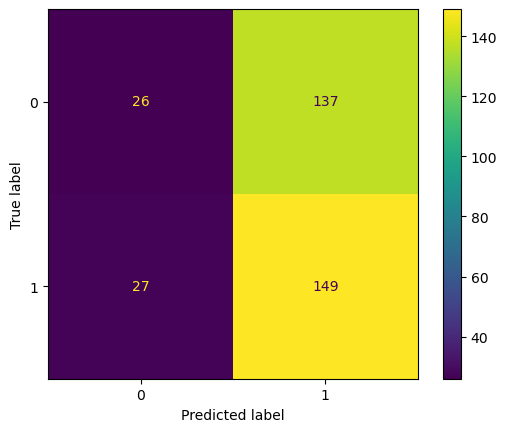

In [68]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# 모델 예측 및 혼동 행렬 계산
y_pred = models[0].predict(features_2024)  # 모델을 사용해 예측
cm = confusion_matrix(target_2024, y_pred)

# 혼동 행렬 출력
print("혼동 행렬:")
print(cm)

# 혼동 행렬의 각 값 추출
TP = cm[1, 1]  # True Positive
TN = cm[0, 0]  # True Negative
FP = cm[0, 1]  # False Positive
FN = cm[1, 0]  # False Negative

# 각 값 출력
print(f"True Positive (TP): {TP}")
print(f"True Negative (TN): {TN}")
print(f"False Positive (FP): {FP}")
print(f"False Negative (FN): {FN}")

# 혼동 행렬 시각화
ConfusionMatrixDisplay.from_estimator(models[0], features_2024, target_2024)
plt.show()

In [70]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
import sqlite3

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn import metrics

import warnings
warnings.filterwarnings('ignore')

# 데이터베이스 파일 경로
db_file = '../btc_data_day_20170901_20241205.db'

# 데이터베이스 연결
con = sqlite3.connect(db_file)

# SQL 쿼리 실행 및 데이터프레임으로 불러오기
query = "SELECT * FROM ticker_data"
df = pd.read_sql_query(query, con)

# 데이터베이스 연결 종료
con.close()

df = df.drop_duplicates(keep='first')
df['datetime'] = pd.to_datetime(df['trade_date'] + ' ' + df['trade_time'])
df = df.sort_values(by='datetime')
df.rename(columns={'trade_price':'closing_price'}, inplace=True)
new_column_order = [
    'datetime', 'type', 'code', 'opening_price', 'closing_price', 'high_price', 'low_price', 'trade_volume', 'trade_date'
]
df = df[new_column_order] 
df = df[df['trade_date']!='2017-09-26']
df = df[df['trade_date']!='2017-09-25']
df['year'] = df['datetime'].dt.year
df['month'] = df['datetime'].dt.month
df['day'] = df['datetime'].dt.day
df['open-close']  = df['opening_price'] - df['closing_price']
df['low-high']  = df['low_price'] - df['high_price']
df['target'] = np.where(df['closing_price'].shift(-1) > df['closing_price'], 1, 0)
df['is_quarter_end'] = np.where(df['month']%3==0,1,0)
df.reset_index(drop=True, inplace=True)

df_all = df[df['trade_date'].str[:4] != '2024']
df2024 = df[df['trade_date'].str[:4] == '2024']

features = df_all[['open-close', 'low-high', 'is_quarter_end']]
target = df_all['target']

features_2024 = df2024[['open-close', 'low-high', 'is_quarter_end']]
target_2024 = df2024['target']

scaler = StandardScaler()
features = scaler.fit_transform(features)
features_2024 = scaler.transform(features_2024)

X_train, X_valid, Y_train, Y_valid = train_test_split(
    features, target, test_size=0.1, random_state=11)

# 모델 및 하이퍼파라미터 설정
models = {
    'Logistic Regression': {
        'model': LogisticRegression(),
        'params': {
            'C': [0.01, 0.1, 1, 10, 100],
            'solver': ['liblinear', 'saga']
        }
    },
    'SVC': {
        'model': SVC(probability=True),
        'params': {
            'C': [0.01, 0.1, 1, 10, 100],
            'kernel': ['linear', 'poly', 'rbf'],
            'degree': [2, 3, 4]
        }
    },
    'XGBoost': {
        'model': XGBClassifier(),
        'params': {
            'learning_rate': [0.01, 0.1, 0.2],
            'max_depth': [3, 5, 7],
            'n_estimators': [100, 200]
        }
    }
}

# 하이퍼파라미터 튜닝
best_models = {}
for model_name, config in models.items():
    grid_search = GridSearchCV(config['model'], config['params'], scoring='f1', cv=3, n_jobs=-1)
    grid_search.fit(X_train, Y_train)
    
    best_models[model_name] = grid_search.best_estimator_
    
    print(f"{model_name} Best Parameters: {grid_search.best_params_}")
    print(f"{model_name} Best F1 Score: {grid_search.best_score_}")

# 최종 모델 평가
for model_name, model in best_models.items():
    print(f'{model_name} : ')
    print('Training Accuracy : ', metrics.roc_auc_score(Y_train, model.predict_proba(X_train)[:, 1]))
    print('Validation Accuracy : ', metrics.roc_auc_score(Y_valid, model.predict_proba(X_valid)[:, 1]))
    print('Validation Accuracy (2024): ', metrics.roc_auc_score(target_2024, model.predict_proba(features_2024)[:, 1]))
    print()


Logistic Regression Best Parameters: {'C': 0.01, 'solver': 'saga'}
Logistic Regression Best F1 Score: 0.6774583244256158
SVC Best Parameters: {'C': 0.1, 'degree': 4, 'kernel': 'poly'}
SVC Best F1 Score: 0.684243872958754
XGBoost Best Parameters: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100}
XGBoost Best F1 Score: 0.6682333643817042
Logistic Regression : 
Training Accuracy :  0.5027333257670337
Validation Accuracy :  0.4855216791787958
Validation Accuracy (2024):  0.5089933073061907

SVC : 
Training Accuracy :  0.4783225513562592
Validation Accuracy :  0.44323578979623107
Validation Accuracy (2024):  0.4859174567763525

XGBoost : 
Training Accuracy :  0.590341618431506
Validation Accuracy :  0.5289949440784434
Validation Accuracy (2024):  0.5313545733407696



Logistic Regression Best Parameters: {'C': 0.01, 'solver': 'saga'}
Logistic Regression Best F1 Score: 0.6774583244256158
SVC Best Parameters: {'C': 0.1, 'degree': 4, 'kernel': 'poly'}
SVC Best F1 Score: 0.684243872958754
XGBoost Best Parameters: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100}
XGBoost Best F1 Score: 0.6682333643817042
Logistic Regression : 
Training Accuracy :  0.5027446752165853
Validation Accuracy :  0.4855982840508657
Validation Accuracy (2024):  0.5089933073061907
혼동 행렬:
[[ 20 143]
 [ 22 154]]
True Positive (TP): 154
True Negative (TN): 20
False Positive (FP): 143
False Negative (FN): 22


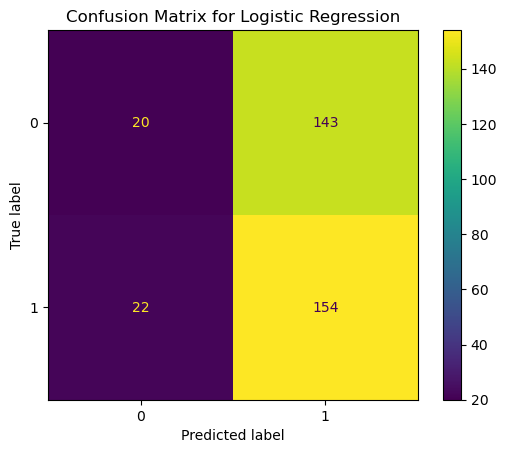

SVC : 
Training Accuracy :  0.4783225513562592
Validation Accuracy :  0.44323578979623107
Validation Accuracy (2024):  0.4859174567763525
혼동 행렬:
[[  9 154]
 [ 13 163]]
True Positive (TP): 163
True Negative (TN): 9
False Positive (FP): 154
False Negative (FN): 13


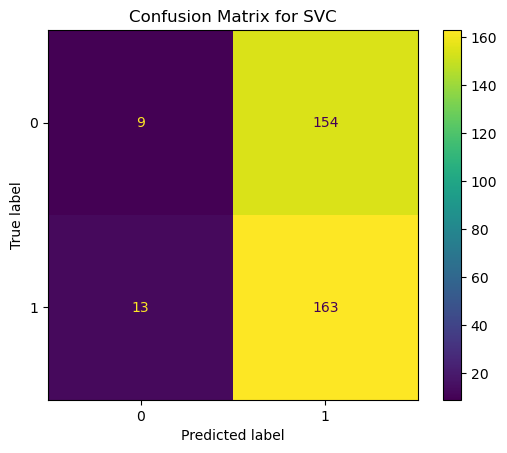

XGBoost : 
Training Accuracy :  0.590341618431506
Validation Accuracy :  0.5289949440784434
Validation Accuracy (2024):  0.5313545733407696
혼동 행렬:
[[ 35 128]
 [ 33 143]]
True Positive (TP): 143
True Negative (TN): 35
False Positive (FP): 128
False Negative (FN): 33


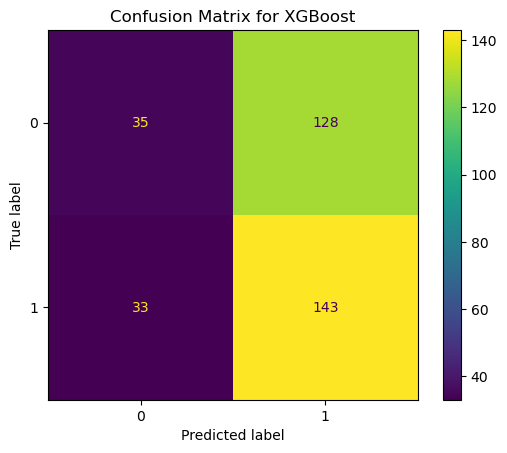

In [71]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
import sqlite3

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn import metrics
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import warnings
warnings.filterwarnings('ignore')

# 데이터베이스 파일 경로
db_file = '../btc_data_day_20170901_20241205.db'

# 데이터베이스 연결
con = sqlite3.connect(db_file)

# SQL 쿼리 실행 및 데이터프레임으로 불러오기
query = "SELECT * FROM ticker_data"
df = pd.read_sql_query(query, con)

# 데이터베이스 연결 종료
con.close()

df = df.drop_duplicates(keep='first')
df['datetime'] = pd.to_datetime(df['trade_date'] + ' ' + df['trade_time'])
df = df.sort_values(by='datetime')
df.rename(columns={'trade_price':'closing_price'}, inplace=True)
new_column_order = [
    'datetime', 'type', 'code', 'opening_price', 'closing_price', 'high_price', 'low_price', 'trade_volume', 'trade_date'
]
df = df[new_column_order] 
df = df[df['trade_date']!='2017-09-26']
df = df[df['trade_date']!='2017-09-25']
df['year'] = df['datetime'].dt.year
df['month'] = df['datetime'].dt.month
df['day'] = df['datetime'].dt.day
df['open-close']  = df['opening_price'] - df['closing_price']
df['low-high']  = df['low_price'] - df['high_price']
df['target'] = np.where(df['closing_price'].shift(-1) > df['closing_price'], 1, 0)
df['is_quarter_end'] = np.where(df['month']%3==0,1,0)
df.reset_index(drop=True, inplace=True)

df_all = df[df['trade_date'].str[:4] != '2024']
df2024 = df[df['trade_date'].str[:4] == '2024']

features = df_all[['open-close', 'low-high', 'is_quarter_end']]
target = df_all['target']

features_2024 = df2024[['open-close', 'low-high', 'is_quarter_end']]
target_2024 = df2024['target']

scaler = StandardScaler()
features = scaler.fit_transform(features)
features_2024 = scaler.transform(features_2024)

X_train, X_valid, Y_train, Y_valid = train_test_split(
    features, target, test_size=0.1, random_state=11)

# 모델 및 하이퍼파라미터 설정
models = {
    'Logistic Regression': {
        'model': LogisticRegression(),
        'params': {
            'C': [0.01, 0.1, 1, 10, 100],
            'solver': ['liblinear', 'saga']
        }
    },
    'SVC': {
        'model': SVC(probability=True),
        'params': {
            'C': [0.01, 0.1, 1, 10, 100],
            'kernel': ['linear', 'poly', 'rbf'],
            'degree': [2, 3, 4]
        }
    },
    'XGBoost': {
        'model': XGBClassifier(),
        'params': {
            'learning_rate': [0.01, 0.1, 0.2],
            'max_depth': [3, 5, 7],
            'n_estimators': [100, 200]
        }
    }
}

# 하이퍼파라미터 튜닝
best_models = {}
for model_name, config in models.items():
    grid_search = GridSearchCV(config['model'], config['params'], scoring='f1', cv=3, n_jobs=-1)
    grid_search.fit(X_train, Y_train)
    
    best_models[model_name] = grid_search.best_estimator_
    
    print(f"{model_name} Best Parameters: {grid_search.best_params_}")
    print(f"{model_name} Best F1 Score: {grid_search.best_score_}")

# 최종 모델 평가 및 혼동 행렬
for model_name, model in best_models.items():
    print(f'{model_name} : ')
    print('Training Accuracy : ', metrics.roc_auc_score(Y_train, model.predict_proba(X_train)[:, 1]))
    print('Validation Accuracy : ', metrics.roc_auc_score(Y_valid, model.predict_proba(X_valid)[:, 1]))
    print('Validation Accuracy (2024): ', metrics.roc_auc_score(target_2024, model.predict_proba(features_2024)[:, 1]))

    # 모델 예측 및 혼동 행렬 계산
    y_pred = model.predict(features_2024)  # 최적의 모델을 사용해 예측
    cm = confusion_matrix(target_2024, y_pred)

    # 혼동 행렬 출력
    print("혼동 행렬:")
    print(cm)

    # 혼동 행렬의 각 값 추출
    TP = cm[1, 1]  # True Positive
    TN = cm[0, 0]  # True Negative
    FP = cm[0, 1]  # False Positive
    FN = cm[1, 0]  # False Negative

    # 각 값 출력
    print(f"True Positive (TP): {TP}")
    print(f"True Negative (TN): {TN}")
    print(f"False Positive (FP): {FP}")
    print(f"False Negative (FN): {FN}")

    # 혼동 행렬 시각화
    ConfusionMatrixDisplay.from_estimator(model, features_2024, target_2024)
    plt.title(f'Confusion Matrix for {model_name}')
    plt.show()


Logistic Regression Best Parameters: {'C': 0.1, 'solver': 'saga'}
Logistic Regression Best Precision Score: 0.5197129129995489
SVC Best Parameters: {'C': 100, 'degree': 2, 'kernel': 'rbf'}
SVC Best Precision Score: 0.5244269839848137
XGBoost Best Parameters: {'learning_rate': 0.2, 'max_depth': 7, 'n_estimators': 200}
XGBoost Best Precision Score: 0.5219035190154094
Logistic Regression : 
Training Accuracy :  0.5030454356297054
Validation Accuracy :  0.485981308411215
Validation Accuracy (2024):  0.5085401561628555
혼동 행렬:
[[ 25 138]
 [ 27 149]]
True Positive (TP): 149
True Negative (TN): 25
False Positive (FP): 138
False Negative (FN): 27


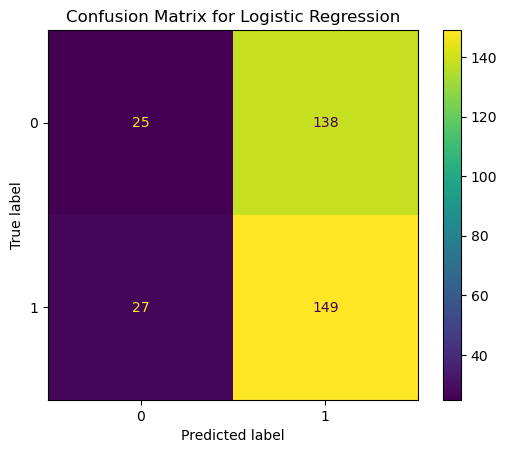

SVC : 
Training Accuracy :  0.4223867892407218
Validation Accuracy :  0.45219855982840507
Validation Accuracy (2024):  0.5240170105967652
혼동 행렬:
[[ 66  97]
 [ 76 100]]
True Positive (TP): 100
True Negative (TN): 66
False Positive (FP): 97
False Negative (FN): 76


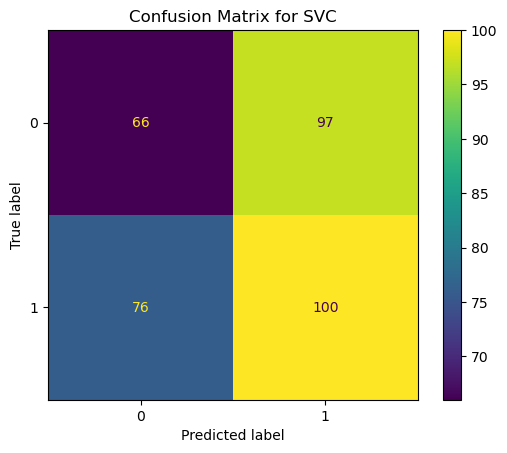

XGBoost : 
Training Accuracy :  0.9731424734233722
Validation Accuracy :  0.5695572238394362
Validation Accuracy (2024):  0.5273284997211378
혼동 행렬:
[[89 74]
 [90 86]]
True Positive (TP): 86
True Negative (TN): 89
False Positive (FP): 74
False Negative (FN): 90


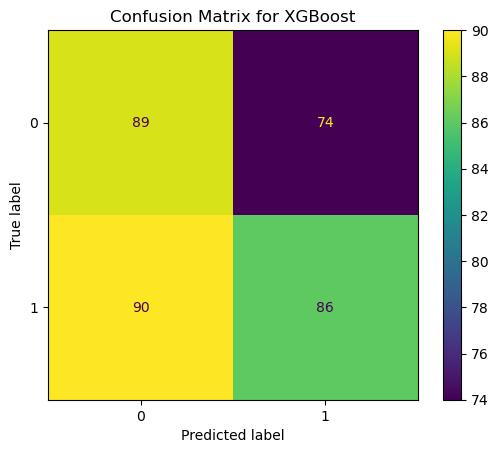

In [72]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
import sqlite3

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn import metrics
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import warnings
warnings.filterwarnings('ignore')

# 데이터베이스 파일 경로
db_file = '../btc_data_day_20170901_20241205.db'

# 데이터베이스 연결
con = sqlite3.connect(db_file)

# SQL 쿼리 실행 및 데이터프레임으로 불러오기
query = "SELECT * FROM ticker_data"
df = pd.read_sql_query(query, con)

# 데이터베이스 연결 종료
con.close()

df = df.drop_duplicates(keep='first')
df['datetime'] = pd.to_datetime(df['trade_date'] + ' ' + df['trade_time'])
df = df.sort_values(by='datetime')
df.rename(columns={'trade_price':'closing_price'}, inplace=True)
new_column_order = [
    'datetime', 'type', 'code', 'opening_price', 'closing_price', 'high_price', 'low_price', 'trade_volume', 'trade_date'
]
df = df[new_column_order] 
df = df[df['trade_date']!='2017-09-26']
df = df[df['trade_date']!='2017-09-25']
df['year'] = df['datetime'].dt.year
df['month'] = df['datetime'].dt.month
df['day'] = df['datetime'].dt.day
df['open-close']  = df['opening_price'] - df['closing_price']
df['low-high']  = df['low_price'] - df['high_price']
df['target'] = np.where(df['closing_price'].shift(-1) > df['closing_price'], 1, 0)
df['is_quarter_end'] = np.where(df['month']%3==0,1,0)
df.reset_index(drop=True, inplace=True)

df_all = df[df['trade_date'].str[:4] != '2024']
df2024 = df[df['trade_date'].str[:4] == '2024']

features = df_all[['open-close', 'low-high', 'is_quarter_end']]
target = df_all['target']

features_2024 = df2024[['open-close', 'low-high', 'is_quarter_end']]
target_2024 = df2024['target']

scaler = StandardScaler()
features = scaler.fit_transform(features)
features_2024 = scaler.transform(features_2024)

X_train, X_valid, Y_train, Y_valid = train_test_split(
    features, target, test_size=0.1, random_state=11)

# 모델 및 하이퍼파라미터 설정
models = {
    'Logistic Regression': {
        'model': LogisticRegression(),
        'params': {
            'C': [0.01, 0.1, 1, 10, 100],
            'solver': ['liblinear', 'saga']
        }
    },
    'SVC': {
        'model': SVC(probability=True),
        'params': {
            'C': [0.01, 0.1, 1, 10, 100],
            'kernel': ['linear', 'poly', 'rbf'],
            'degree': [2, 3, 4]
        }
    },
    'XGBoost': {
        'model': XGBClassifier(),
        'params': {
            'learning_rate': [0.01, 0.1, 0.2],
            'max_depth': [3, 5, 7],
            'n_estimators': [100, 200]
        }
    }
}

# 하이퍼파라미터 튜닝
best_models = {}
for model_name, config in models.items():
    grid_search = GridSearchCV(config['model'], config['params'], scoring='precision', cv=3, n_jobs=-1)
    grid_search.fit(X_train, Y_train)
    
    best_models[model_name] = grid_search.best_estimator_
    
    print(f"{model_name} Best Parameters: {grid_search.best_params_}")
    print(f"{model_name} Best Precision Score: {grid_search.best_score_}")

# 최종 모델 평가 및 혼동 행렬
for model_name, model in best_models.items():
    print(f'{model_name} : ')
    print('Training Accuracy : ', metrics.roc_auc_score(Y_train, model.predict_proba(X_train)[:, 1]))
    print('Validation Accuracy : ', metrics.roc_auc_score(Y_valid, model.predict_proba(X_valid)[:, 1]))
    print('Validation Accuracy (2024): ', metrics.roc_auc_score(target_2024, model.predict_proba(features_2024)[:, 1]))

    # 모델 예측 및 혼동 행렬 계산
    y_pred = model.predict(features_2024)  # 최적의 모델을 사용해 예측
    cm = confusion_matrix(target_2024, y_pred)

    # 혼동 행렬 출력
    print("혼동 행렬:")
    print(cm)

    # 혼동 행렬의 각 값 추출
    TP = cm[1, 1]  # True Positive
    TN = cm[0, 0]  # True Negative
    FP = cm[0, 1]  # False Positive
    FN = cm[1, 0]  # False Negative

    # 각 값 출력
    print(f"True Positive (TP): {TP}")
    print(f"True Negative (TN): {TN}")
    print(f"False Positive (FP): {FP}")
    print(f"False Negative (FN): {FN}")

    # 혼동 행렬 시각화
    ConfusionMatrixDisplay.from_estimator(model, features_2024, target_2024)
    plt.title(f'Confusion Matrix for {model_name}')
    plt.show()


Logistic Regression Best Parameters: {'C': 0.001, 'penalty': 'l2', 'solver': 'liblinear'}
Logistic Regression Best Precision Score: 0.5204298787787288
SVC Best Parameters: {'C': 1, 'degree': 2, 'gamma': 0.1, 'kernel': 'sigmoid'}
SVC Best Precision Score: 0.5359542306508166
XGBoost Best Parameters: {'colsample_bytree': 0.5, 'gamma': 0.1, 'learning_rate': 0.3, 'max_depth': 5, 'n_estimators': 250, 'reg_alpha': 0.1, 'reg_lambda': 0, 'subsample': 0.5}
XGBoost Best Precision Score: 0.5400431521227375
Logistic Regression : 
Training Accuracy :  0.502059925093633
Validation Accuracy :  0.4832235330166999
Validation Accuracy (2024):  0.5101784718349135
혼동 행렬:
[[ 25 138]
 [ 24 152]]
True Positive (TP): 152
True Negative (TN): 25
False Positive (FP): 138
False Negative (FN): 24


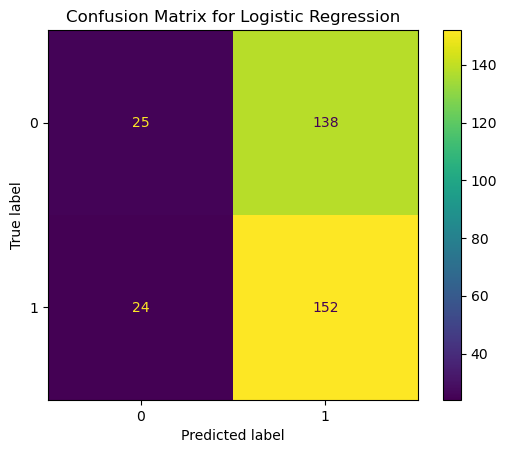

SVC : 
Training Accuracy :  0.5049587636666288
Validation Accuracy :  0.4847556304580971
Validation Accuracy (2024):  0.4988148354712772
혼동 행렬:
[[86 77]
 [96 80]]
True Positive (TP): 80
True Negative (TN): 86
False Positive (FP): 77
False Negative (FN): 96


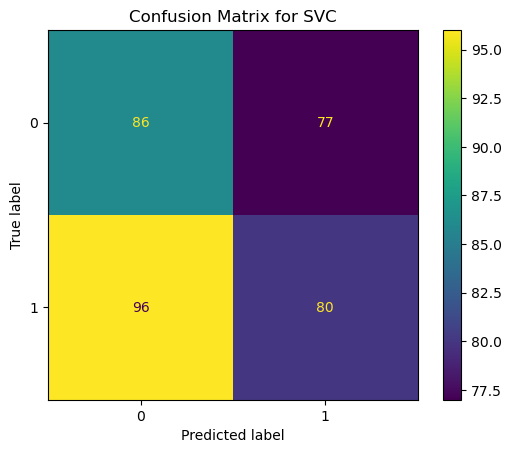

XGBoost : 
Training Accuracy :  0.7500714069534294
Validation Accuracy :  0.5322506511414126
Validation Accuracy (2024):  0.5421953430005577
혼동 행렬:
[[95 68]
 [93 83]]
True Positive (TP): 83
True Negative (TN): 95
False Positive (FP): 68
False Negative (FN): 93


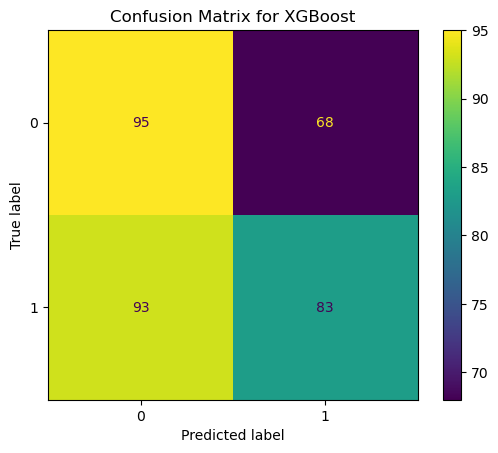

In [73]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
import sqlite3

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn import metrics
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import warnings
warnings.filterwarnings('ignore')

# 데이터베이스 파일 경로
db_file = '../btc_data_day_20170901_20241205.db'

# 데이터베이스 연결
con = sqlite3.connect(db_file)

# SQL 쿼리 실행 및 데이터프레임으로 불러오기
query = "SELECT * FROM ticker_data"
df = pd.read_sql_query(query, con)

# 데이터베이스 연결 종료
con.close()

df = df.drop_duplicates(keep='first')
df['datetime'] = pd.to_datetime(df['trade_date'] + ' ' + df['trade_time'])
df = df.sort_values(by='datetime')
df.rename(columns={'trade_price':'closing_price'}, inplace=True)
new_column_order = [
    'datetime', 'type', 'code', 'opening_price', 'closing_price', 'high_price', 'low_price', 'trade_volume', 'trade_date'
]
df = df[new_column_order] 
df = df[df['trade_date']!='2017-09-26']
df = df[df['trade_date']!='2017-09-25']
df['year'] = df['datetime'].dt.year
df['month'] = df['datetime'].dt.month
df['day'] = df['datetime'].dt.day
df['open-close']  = df['opening_price'] - df['closing_price']
df['low-high']  = df['low_price'] - df['high_price']
df['target'] = np.where(df['closing_price'].shift(-1) > df['closing_price'], 1, 0)
df['is_quarter_end'] = np.where(df['month']%3==0,1,0)
df.reset_index(drop=True, inplace=True)

df_all = df[df['trade_date'].str[:4] != '2024']
df2024 = df[df['trade_date'].str[:4] == '2024']

features = df_all[['open-close', 'low-high', 'is_quarter_end']]
target = df_all['target']

features_2024 = df2024[['open-close', 'low-high', 'is_quarter_end']]
target_2024 = df2024['target']

scaler = StandardScaler()
features = scaler.fit_transform(features)
features_2024 = scaler.transform(features_2024)

X_train, X_valid, Y_train, Y_valid = train_test_split(
    features, target, test_size=0.1, random_state=11)

# 모델 및 하이퍼파라미터 설정
models = {
    'Logistic Regression': {
        'model': LogisticRegression(),
        'params': {
            'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
            'solver': ['liblinear', 'saga', 'lbfgs'],
            'penalty': ['l1', 'l2', 'elasticnet', None]
        }
    },
    'SVC': {
        'model': SVC(probability=True),
        'params': {
            'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
            'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
            'degree': [2, 3, 4, 5],
            'gamma': ['scale', 'auto', 0.001, 0.01, 0.1, 1]
        }
    },
    'XGBoost': {
        'model': XGBClassifier(),
        'params': {
            'learning_rate': [0.01, 0.05, 0.1, 0.2, 0.3],
            'max_depth': [3, 4, 5, 6, 7, 8, 9, 10],
            'n_estimators': [50, 100, 150, 200, 250],
            'subsample': [0.5, 0.7, 0.9, 1.0],
            'colsample_bytree': [0.5, 0.7, 1.0],
            'gamma': [0, 0.1, 0.2, 0.3],
            'reg_alpha': [0, 0.1, 1, 10],
            'reg_lambda': [0, 0.1, 1, 10]
        }
    }
}

# 하이퍼파라미터 튜닝
best_models = {}
for model_name, config in models.items():
    grid_search = GridSearchCV(config['model'], config['params'], scoring='precision', cv=3, n_jobs=-1)
    grid_search.fit(X_train, Y_train)
    
    best_models[model_name] = grid_search.best_estimator_
    
    print(f"{model_name} Best Parameters: {grid_search.best_params_}")
    print(f"{model_name} Best Precision Score: {grid_search.best_score_}")

# 최종 모델 평가 및 혼동 행렬
for model_name, model in best_models.items():
    print(f'{model_name} : ')
    print('Training Accuracy : ', metrics.roc_auc_score(Y_train, model.predict_proba(X_train)[:, 1]))
    print('Validation Accuracy : ', metrics.roc_auc_score(Y_valid, model.predict_proba(X_valid)[:, 1]))
    print('Validation Accuracy (2024): ', metrics.roc_auc_score(target_2024, model.predict_proba(features_2024)[:, 1]))

    # 모델 예측 및 혼동 행렬 계산
    y_pred = model.predict(features_2024)  # 최적의 모델을 사용해 예측
    cm = confusion_matrix(target_2024, y_pred)

    # 혼동 행렬 출력
    print("혼동 행렬:")
    print(cm)

    # 혼동 행렬의 각 값 추출
    TP = cm[1, 1]  # True Positive
    TN = cm[0, 0]  # True Negative
    FP = cm[0, 1]  # False Positive
    FN = cm[1, 0]  # False Negative

    # 각 값 출력
    print(f"True Positive (TP): {TP}")
    print(f"True Negative (TN): {TN}")
    print(f"False Positive (FP): {FP}")
    print(f"False Negative (FN): {FN}")

    # 혼동 행렬 시각화
    ConfusionMatrixDisplay.from_estimator(model, features_2024, target_2024)
    plt.title(f'Confusion Matrix for {model_name}')
    plt.show()

In [74]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sqlite3

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn import metrics
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import warnings
warnings.filterwarnings('ignore')

# 데이터베이스 파일 경로
db_file = '../btc_data_day_20170901_20241205.db'

# 데이터베이스 연결
con = sqlite3.connect(db_file)

# SQL 쿼리 실행 및 데이터프레임으로 불러오기
query = "SELECT * FROM ticker_data"
df = pd.read_sql_query(query, con)

# 데이터베이스 연결 종료
con.close()

df = df.drop_duplicates(keep='first')
df['datetime'] = pd.to_datetime(df['trade_date'] + ' ' + df['trade_time'])
df = df.sort_values(by='datetime')
df.rename(columns={'trade_price':'closing_price'}, inplace=True)
new_column_order = [
    'datetime', 'type', 'code', 'opening_price', 'closing_price', 'high_price', 'low_price', 'trade_volume', 'trade_date'
]
df = df[new_column_order] 
df = df[df['trade_date']!='2017-09-26']
df = df[df['trade_date']!='2017-09-25']
df['year'] = df['datetime'].dt.year
df['month'] = df['datetime'].dt.month
df['day'] = df['datetime'].dt.day
df['open-close']  = df['opening_price'] - df['closing_price']
df['low-high']  = df['low_price'] - df['high_price']
df['target'] = np.where(df['closing_price'].shift(-1) > df['closing_price'], 1, 0)
df['is_quarter_end'] = np.where(df['month']%3==0,1,0)
df.reset_index(drop=True, inplace=True)

df_all = df[df['trade_date'].str[:4] != '2024']
df2024 = df[df['trade_date'].str[:4] == '2024']

features = df_all[['open-close', 'low-high', 'is_quarter_end']]
target = df_all['target']

features_2024 = df2024[['open-close', 'low-high', 'is_quarter_end']]
target_2024 = df2024['target']

scaler = StandardScaler()
features = scaler.fit_transform(features)
features_2024 = scaler.transform(features_2024)

X_train, X_valid, Y_train, Y_valid = train_test_split(
    features, target, test_size=0.1, random_state=11)

# 모델 및 하이퍼파라미터 설정
models = {
    'Logistic Regression': {
        'model': LogisticRegression(),
        'params': {
            'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
            'solver': ['liblinear', 'saga', 'lbfgs'],
            'penalty': ['l1', 'l2', 'elasticnet', None]
        }
    },
    'SVC': {
        'model': SVC(probability=True),
        'params': {
            'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
            'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
            'degree': [2, 3, 4, 5],
            'gamma': ['scale', 'auto', 0.001, 0.01, 0.1, 1]
        }
    },
    'XGBoost': {
        'model': XGBClassifier(),
        'params': {
            'learning_rate': [0.01, 0.05, 0.1, 0.2, 0.3],
            'max_depth': [3, 4, 5, 6, 7, 8, 9, 10],
            'n_estimators': [50, 100, 150, 200, 250],
            'subsample': [0.5, 0.7, 0.9, 1.0],
            'colsample_bytree': [0.5, 0.7, 1.0],
            'gamma': [0, 0.1, 0.2, 0.3],
            'reg_alpha': [0, 0.1, 1, 10],
            'reg_lambda': [0, 0.1, 1, 10]
        }
    }
}

# 하이퍼파라미터 튜닝
best_models = {}
for model_name, config in models.items():
    grid_search = GridSearchCV(
        config['model'], 
        config['params'], 
        scoring=['precision', 'f1', 'accuracy', 'recall'],  # 여러 평가 지표
        refit='f1',  # 최적화 기준으로 사용할 지표
        cv=3, 
        n_jobs=-1
    )
    grid_search.fit(X_train, Y_train)

    best_models[model_name] = grid_search.best_estimator_
    
    print(f"{model_name} Best Parameters: {grid_search.best_params_}")
    print(f"{model_name} Best F1 Score: {grid_search.best_score_}")
    print(f"{model_name} Best Precision Score: {grid_search.cv_results_['mean_test_precision'][grid_search.best_index_]}")
    print(f"{model_name} Best Accuracy Score: {grid_search.cv_results_['mean_test_accuracy'][grid_search.best_index_]}")
    print(f"{model_name} Best Recall Score: {grid_search.cv_results_['mean_test_recall'][grid_search.best_index_]}")

# 최종 모델 평가 및 혼동 행렬
for model_name, model in best_models.items():
    print(f'\n{model_name} : ')
    print('Training Accuracy : ', metrics.roc_auc_score(Y_train, model.predict_proba(X_train)[:, 1]))
    print('Validation Accuracy : ', metrics.roc_auc_score(Y_valid, model.predict_proba(X_valid)[:, 1]))
    print('Validation Accuracy (2024): ', metrics.roc_auc_score(target_2024, model.predict_proba(features_2024)[:, 1]))

    # 모델 예측 및 혼동 행렬 계산
    y_pred = model.predict(features_2024)  # 최적의 모델을 사용해 예측
    cm = confusion_matrix(target_2024, y_pred)

    # 혼동 행렬 출력
    print("혼동 행렬:")
    print(cm)

    # 혼동 행렬의 각 값 추출
    TP = cm[1, 1]  # True Positive
    TN = cm[0, 0]  # True Negative
    FP = cm[0, 1]  # False Positive
    FN = cm[1, 0]  # False Negative

    # 각 값 출력
    print(f"True Positive (TP): {TP}")
    print(f"True Negative (TN): {TN}")
    print(f"False Positive (FP): {FP}")
    print(f"False Negative (FN): {FN}")

    # 혼동 행렬 시각화
    ConfusionMatrixDisplay.from_estimator(model, features_2024, target_2024)
    plt.title(f'Confusion Matrix for {model_name}')
    plt.show()


Logistic Regression Best Parameters: {'C': 0.001, 'penalty': 'l1', 'solver': 'saga'}
Logistic Regression Best F1 Score: 0.6833013435700576
Logistic Regression Best Precision Score: 0.5189504373177842
Logistic Regression Best Accuracy Score: 0.5189504373177842
Logistic Regression Best Recall Score: 1.0


KeyboardInterrupt: 

# cv사용 3개의 모델 학습 평가

Logistic Regression Best Parameters: {'C': 0.001, 'penalty': 'l2', 'solver': 'liblinear'}
Logistic Regression Best Precision Score: 0.5204298787787288
SVC Best Parameters: {'C': 1, 'degree': 2, 'gamma': 0.1, 'kernel': 'sigmoid'}
SVC Best Precision Score: 0.5359542306508166
XGBoost Best Parameters: {'colsample_bytree': 0.5, 'gamma': 0.1, 'learning_rate': 0.3, 'max_depth': 5, 'n_estimators': 250, 'reg_alpha': 0.1, 'reg_lambda': 0, 'subsample': 0.5}
XGBoost Best Precision Score: 0.5400431521227375
Logistic Regression : 
Training Accuracy :  0.502059925093633
Validation Accuracy :  0.4832235330166999
Validation Accuracy (2024):  0.5101784718349135
혼동 행렬:
[[ 25 138]
 [ 24 152]]
True Positive (TP): 152
True Negative (TN): 25
False Positive (FP): 138
False Negative (FN): 24


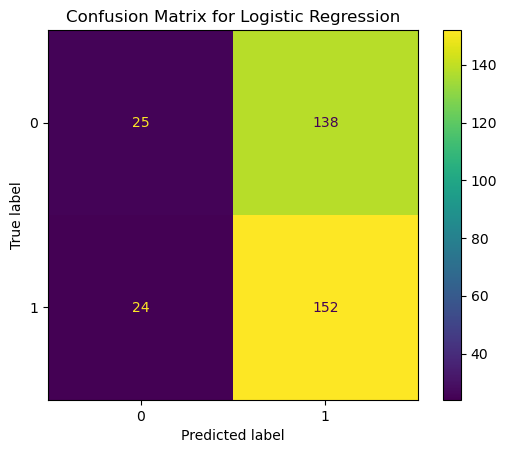

Logistic Regression 모델이 저장되었습니다.
SVC : 
Training Accuracy :  0.4950431279082965
Validation Accuracy :  0.5153209744139728
Validation Accuracy (2024):  0.5011154489682097
혼동 행렬:
[[86 77]
 [96 80]]
True Positive (TP): 80
True Negative (TN): 86
False Positive (FP): 77
False Negative (FN): 96


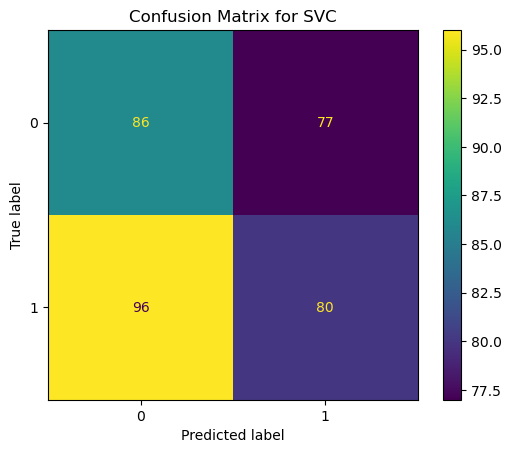

SVC 모델이 저장되었습니다.
XGBoost : 
Training Accuracy :  0.7500714069534294
Validation Accuracy :  0.5322506511414126
Validation Accuracy (2024):  0.5421953430005577
혼동 행렬:
[[95 68]
 [93 83]]
True Positive (TP): 83
True Negative (TN): 95
False Positive (FP): 68
False Negative (FN): 93


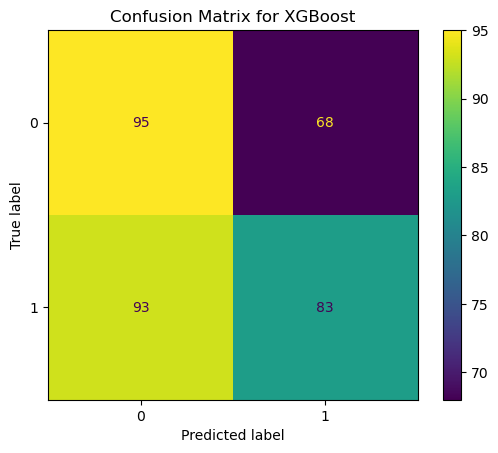

XGBoost 모델이 저장되었습니다.
모든 모델이 저장되었습니다.


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
import sqlite3
import joblib

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn import metrics
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import warnings
warnings.filterwarnings('ignore')

# 데이터베이스 파일 경로
db_file = '../btc_data_day_20170901_20241205.db'

# 데이터베이스 연결
con = sqlite3.connect(db_file)

# SQL 쿼리 실행 및 데이터프레임으로 불러오기
query = "SELECT * FROM ticker_data"
df = pd.read_sql_query(query, con)

# 데이터베이스 연결 종료c
con.close()

df = df.drop_duplicates(keep='first')
df['datetime'] = pd.to_datetime(df['trade_date'] + ' ' + df['trade_time'])
df = df.sort_values(by='datetime')
df.rename(columns={'trade_price':'closing_price'}, inplace=True)
new_column_order = [
    'datetime', 'type', 'code', 'opening_price', 'closing_price', 'high_price', 'low_price', 'trade_volume', 'trade_date'
]
df = df[new_column_order] 
df = df[df['trade_date']!='2017-09-26']
df = df[df['trade_date']!='2017-09-25']
df['year'] = df['datetime'].dt.year
df['month'] = df['datetime'].dt.month
df['day'] = df['datetime'].dt.day
df['open-close']  = df['opening_price'] - df['closing_price']
df['low-high']  = df['low_price'] - df['high_price']
df['target'] = np.where(df['closing_price'].shift(-1) > df['closing_price'], 1, 0)
df['is_quarter_end'] = np.where(df['month']%3==0,1,0)
df.reset_index(drop=True, inplace=True)

df_all = df[df['trade_date'].str[:4] != '2024']
df2024 = df[df['trade_date'].str[:4] == '2024']

features = df_all[['open-close', 'low-high', 'is_quarter_end']]
target = df_all['target']

features_2024 = df2024[['open-close', 'low-high', 'is_quarter_end']]
target_2024 = df2024['target']

scaler = StandardScaler()
features = scaler.fit_transform(features)
features_2024 = scaler.transform(features_2024)

X_train, X_valid, Y_train, Y_valid = train_test_split(
    features, target, test_size=0.1, random_state=11)

# 모델 및 하이퍼파라미터 설정
models = {
    'Logistic Regression': {
        'model': LogisticRegression(),
        'params': {
            'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
            'solver': ['liblinear', 'saga', 'lbfgs'],
            'penalty': ['l1', 'l2', 'elasticnet', None]
        }
    },
    'SVC': {
        'model': SVC(probability=True),
        'params': {
            'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
            'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
            'degree': [2, 3, 4, 5],
            'gamma': ['scale', 'auto', 0.001, 0.01, 0.1, 1]
        }
    },
    'XGBoost': {
        'model': XGBClassifier(),
        'params': {
            'learning_rate': [0.01, 0.05, 0.1, 0.2, 0.3],
            'max_depth': [3, 4, 5, 6, 7, 8, 9, 10],
            'n_estimators': [50, 100, 150, 200, 250],
            'subsample': [0.5, 0.7, 0.9, 1.0],
            'colsample_bytree': [0.5, 0.7, 1.0],
            'gamma': [0, 0.1, 0.2, 0.3],
            'reg_alpha': [0, 0.1, 1, 10],
            'reg_lambda': [0, 0.1, 1, 10]
        }
    }
}

# 하이퍼파라미터 튜닝
best_models = {}
for model_name, config in models.items():
    grid_search = GridSearchCV(config['model'], config['params'], scoring='precision', cv=3, n_jobs=-1)
    grid_search.fit(X_train, Y_train)
    
    best_models[model_name] = grid_search.best_estimator_
    
    print(f"{model_name} Best Parameters: {grid_search.best_params_}")
    print(f"{model_name} Best Precision Score: {grid_search.best_score_}")

# 최종 모델 평가 및 혼동 행렬
for model_name, model in best_models.items():
    print(f'{model_name} : ')
    print('Training Accuracy : ', metrics.roc_auc_score(Y_train, model.predict_proba(X_train)[:, 1]))
    print('Validation Accuracy : ', metrics.roc_auc_score(Y_valid, model.predict_proba(X_valid)[:, 1]))
    print('Validation Accuracy (2024): ', metrics.roc_auc_score(target_2024, model.predict_proba(features_2024)[:, 1]))

    # 모델 예측 및 혼동 행렬 계산
    y_pred = model.predict(features_2024)  # 최적의 모델을 사용해 예측
    cm = confusion_matrix(target_2024, y_pred)

    # 혼동 행렬 출력
    print("혼동 행렬:")
    print(cm)

    # 혼동 행렬의 각 값 추출
    TP = cm[1, 1]  # True Positive
    TN = cm[0, 0]  # True Negative
    FP = cm[0, 1]  # False Positive
    FN = cm[1, 0]  # False Negative

    # 각 값 출력
    print(f"True Positive (TP): {TP}")
    print(f"True Negative (TN): {TN}")
    print(f"False Positive (FP): {FP}")
    print(f"False Negative (FN): {FN}")

    # 혼동 행렬 시각화
    ConfusionMatrixDisplay.from_estimator(model, features_2024, target_2024)
    plt.title(f'Confusion Matrix for {model_name}')
    plt.show()

    # 모델 저장
    joblib.dump(model, f'best_model_{model_name.replace(" ", "_")}.pkl')
    print(f"{model_name} 모델이 저장되었습니다.")

# XGBoost 모델 저장
best_xgboost_model = best_models['XGBoost']
joblib.dump(best_xgboost_model, 'best_xgboost_model.pkl')

print("모든 모델이 저장되었습니다.")


# TS 사용 모델 3개 학습 및 평가

Logistic Regression Best Parameters: {'C': 0.1, 'penalty': 'l2', 'solver': 'saga'}
Logistic Regression Best Precision Score: 0.5230752821806512
SVC Best Parameters: {'C': 100, 'degree': 2, 'gamma': 0.1, 'kernel': 'sigmoid'}
SVC Best Precision Score: 0.5484380783678954
XGBoost Best Parameters: {'colsample_bytree': 0.7, 'gamma': 0.3, 'learning_rate': 0.01, 'max_depth': 10, 'n_estimators': 150, 'reg_alpha': 0, 'reg_lambda': 0.1, 'subsample': 1.0}
XGBoost Best Precision Score: 0.5385524722805136
Logistic Regression : 
Training Accuracy :  0.5030407066923921
Validation Accuracy :  0.485981308411215
Validation Accuracy (2024):  0.5085052983825991
혼동 행렬:
[[ 25 138]
 [ 27 149]]
True Positive (TP): 149
True Negative (TN): 25
False Positive (FP): 138
False Negative (FN): 27


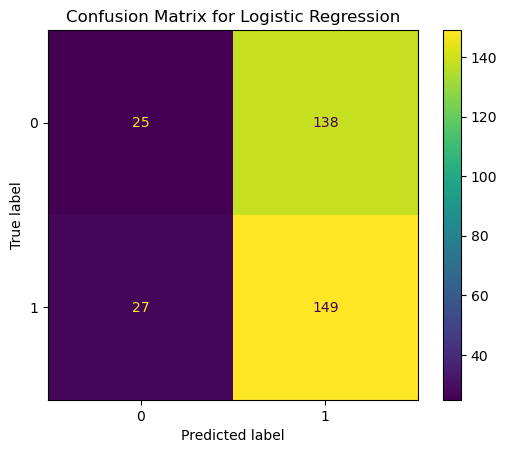

Logistic Regression 모델이 저장되었습니다.
SVC : 
Training Accuracy :  0.5172265728445504
Validation Accuracy :  0.4706603339972422
Validation Accuracy (2024):  0.4965142219743446
혼동 행렬:
[[77 86]
 [86 90]]
True Positive (TP): 90
True Negative (TN): 77
False Positive (FP): 86
False Negative (FN): 86


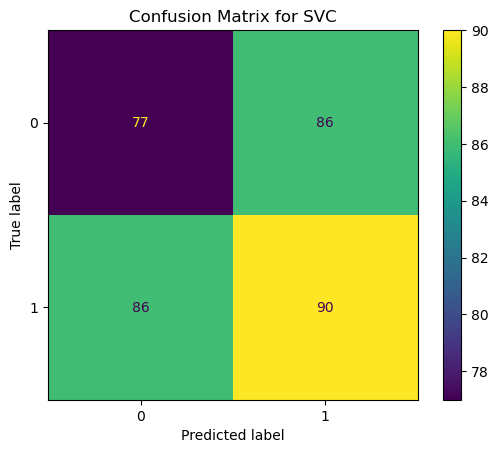

SVC 모델이 저장되었습니다.
XGBoost : 
Training Accuracy :  0.7758583021223471
Validation Accuracy :  0.5888999540370767
Validation Accuracy (2024):  0.5050718070273286
혼동 행렬:
[[ 64  99]
 [ 72 104]]
True Positive (TP): 104
True Negative (TN): 64
False Positive (FP): 99
False Negative (FN): 72


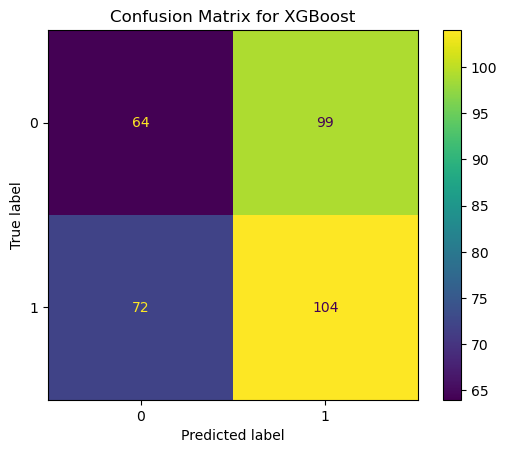

XGBoost 모델이 저장되었습니다.
모든 모델이 저장되었습니다.


In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sqlite3
import joblib

from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn import metrics
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import warnings
warnings.filterwarnings('ignore')

# 데이터베이스 파일 경로
db_file = '../btc_data_day_20170901_20241205.db'

# 데이터베이스 연결
con = sqlite3.connect(db_file)

# SQL 쿼리 실행 및 데이터프레임으로 불러오기
query = "SELECT * FROM ticker_data"
df = pd.read_sql_query(query, con)

# 데이터베이스 연결 종료
con.close()

df = df.drop_duplicates(keep='first')
df['datetime'] = pd.to_datetime(df['trade_date'] + ' ' + df['trade_time'])
df = df.sort_values(by='datetime')
df.rename(columns={'trade_price':'closing_price'}, inplace=True)
new_column_order = [
    'datetime', 'type', 'code', 'opening_price', 'closing_price', 'high_price', 'low_price', 'trade_volume', 'trade_date'
]
df = df[new_column_order] 
df = df[df['trade_date'] != '2017-09-26']
df = df[df['trade_date'] != '2017-09-25']
df['year'] = df['datetime'].dt.year
df['month'] = df['datetime'].dt.month
df['day'] = df['datetime'].dt.day
df['open-close']  = df['opening_price'] - df['closing_price']
df['low-high']  = df['low_price'] - df['high_price']
df['target'] = np.where(df['closing_price'].shift(-1) > df['closing_price'], 1, 0)
df['is_quarter_end'] = np.where(df['month'] % 3 == 0, 1, 0)
df.reset_index(drop=True, inplace=True)

df_all = df[df['trade_date'].str[:4] != '2024']
df2024 = df[df['trade_date'].str[:4] == '2024']

features = df_all[['open-close', 'low-high', 'is_quarter_end']]
target = df_all['target']

features_2024 = df2024[['open-close', 'low-high', 'is_quarter_end']]
target_2024 = df2024['target']

scaler = StandardScaler()
features = scaler.fit_transform(features)
features_2024 = scaler.transform(features_2024)

X_train, X_valid, Y_train, Y_valid = train_test_split(
    features, target, test_size=0.1, random_state=11)

# 모델 및 하이퍼파라미터 설정
models = {
    'Logistic Regression': {
        'model': LogisticRegression(),
        'params': {
            'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
            'solver': ['liblinear', 'saga', 'lbfgs'],
            'penalty': ['l1', 'l2', 'elasticnet', None]
        }
    },
    'SVC': {
        'model': SVC(probability=True),
        'params': {
            'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
            'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
            'degree': [2, 3, 4, 5],
            'gamma': ['scale', 'auto', 0.001, 0.01, 0.1, 1]
        }
    },
    'XGBoost': {
        'model': XGBClassifier(),
        'params': {
            'learning_rate': [0.01, 0.05, 0.1, 0.2, 0.3],
            'max_depth': [3, 4, 5, 6, 7, 8, 9, 10],
            'n_estimators': [50, 100, 150, 200, 250],
            'subsample': [0.5, 0.7, 0.9, 1.0],
            'colsample_bytree': [0.5, 0.7, 1.0],
            'gamma': [0, 0.1, 0.2, 0.3],
            'reg_alpha': [0, 0.1, 1, 10],
            'reg_lambda': [0, 0.1, 1, 10]
        }
    }
}

# 하이퍼파라미터 튜닝
best_models = {}
tscv = TimeSeriesSplit(n_splits=3)  # 시계열 데이터에 적합한 교차 검증

for model_name, config in models.items():
    grid_search = GridSearchCV(config['model'], config['params'], scoring='precision', cv=tscv, n_jobs=-1)
    grid_search.fit(X_train, Y_train)
    
    best_models[model_name] = grid_search.best_estimator_
    
    print(f"{model_name} Best Parameters: {grid_search.best_params_}")
    print(f"{model_name} Best Precision Score: {grid_search.best_score_}")

# 최종 모델 평가 및 혼동 행렬
for model_name, model in best_models.items():
    print(f'{model_name} : ')
    print('Training Accuracy : ', metrics.roc_auc_score(Y_train, model.predict_proba(X_train)[:, 1]))
    print('Validation Accuracy : ', metrics.roc_auc_score(Y_valid, model.predict_proba(X_valid)[:, 1]))
    print('Validation Accuracy (2024): ', metrics.roc_auc_score(target_2024, model.predict_proba(features_2024)[:, 1]))

    # 모델 예측 및 혼동 행렬 계산
    y_pred = model.predict(features_2024)  # 최적의 모델을 사용해 예측
    cm = confusion_matrix(target_2024, y_pred)

    # 혼동 행렬 출력
    print("혼동 행렬:")
    print(cm)

    # 혼동 행렬의 각 값 추출
    TP = cm[1, 1]  # True Positive
    TN = cm[0, 0]  # True Negative
    FP = cm[0, 1]  # False Positive
    FN = cm[1, 0]  # False Negative

    # 각 값 출력
    print(f"True Positive (TP): {TP}")
    print(f"True Negative (TN): {TN}")
    print(f"False Positive (FP): {FP}")
    print(f"False Negative (FN): {FN}")

    # 혼동 행렬 시각화
    ConfusionMatrixDisplay.from_estimator(model, features_2024, target_2024)
    plt.title(f'Confusion Matrix for {model_name}')
    plt.show()

    # 모델 저장
    joblib.dump(model, f'best_model_{model_name.replace(" ", "_")}.pkl')
    print(f"{model_name} 모델이 저장되었습니다.")

print("모든 모델이 저장되었습니다.")


Fitting 3 folds for each of 1 candidates, totalling 3 fits
Random Forest Best Parameters: {}
Random Forest Best Precision Score: 0.5164886480908153
Training Accuracy :  0.9339925471947945
Validation Accuracy :  0.5517848935192279
Validation Accuracy (2024):  0.49829196876742887
혼동 행렬:
[[85 78]
 [85 91]]
True Positive (TP): 91
True Negative (TN): 85
False Positive (FP): 78
False Negative (FN): 85


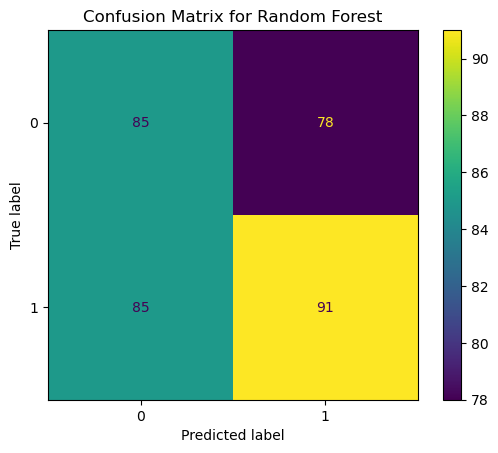

랜덤 포레스트 모델이 저장되었습니다.


In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sqlite3
import joblib

from sklearn.model_selection import TimeSeriesSplit, GridSearchCV, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import warnings
warnings.filterwarnings('ignore')

# 데이터베이스 파일 경로
db_file = '../btc_data_day_20170901_20241205.db'

# 데이터베이스 연결
con = sqlite3.connect(db_file)

# SQL 쿼리 실행 및 데이터프레임으로 불러오기
query = "SELECT * FROM ticker_data"
df = pd.read_sql_query(query, con)

# 데이터베이스 연결 종료
con.close()

# 데이터 전처리
df = df.drop_duplicates(keep='first')
df['datetime'] = pd.to_datetime(df['trade_date'] + ' ' + df['trade_time'])
df = df.sort_values(by='datetime')
df.rename(columns={'trade_price':'closing_price'}, inplace=True)

# 필요한 열만 선택
new_column_order = [
    'datetime', 'type', 'code', 'opening_price', 'closing_price', 
    'high_price', 'low_price', 'trade_volume', 'trade_date'
]
df = df[new_column_order] 
df = df[df['trade_date'] != '2017-09-26']
df = df[df['trade_date'] != '2017-09-25']

# 특성 및 타겟 생성
df['year'] = df['datetime'].dt.year
df['month'] = df['datetime'].dt.month
df['day'] = df['datetime'].dt.day
df['open-close']  = df['opening_price'] - df['closing_price']
df['low-high']  = df['low_price'] - df['high_price']
df['target'] = np.where(df['closing_price'].shift(-1) > df['closing_price'], 1, 0)
df['is_quarter_end'] = np.where(df['month'] % 3 == 0, 1, 0)
df.reset_index(drop=True, inplace=True)

# 데이터 분할
df_all = df[df['trade_date'].str[:4] != '2024']
df2024 = df[df['trade_date'].str[:4] == '2024']

features = df_all[['open-close', 'low-high', 'is_quarter_end']]
target = df_all['target']

features_2024 = df2024[['open-close', 'low-high', 'is_quarter_end']]
target_2024 = df2024['target']

# 데이터 스케일링
scaler = StandardScaler()
features = scaler.fit_transform(features)
features_2024 = scaler.transform(features_2024)

# 학습 및 검증 데이터 분할
X_train, X_valid, Y_train, Y_valid = train_test_split(
    features, target, test_size=0.1, random_state=11)

# 랜덤 포레스트 모델 및 하이퍼파라미터 설정
rf_model = RandomForestClassifier()
rf_params = {
    'n_estimators': 50,
    'max_depth': 40,
    'min_samples_split': 5,
    'min_samples_leaf': 4,
    'max_features': 'sqrt',
    'bootstrap': True
}

# 하이퍼파라미터 설정 후 모델 학습
rf_model.set_params(**rf_params)

# Time Series Split을 사용한 하이퍼파라미터 튜닝
tscv = TimeSeriesSplit(n_splits=3)
grid_search = GridSearchCV(rf_model, param_grid={}, scoring='precision', cv=tscv, n_jobs=-1, verbose=1)
grid_search.fit(X_train, Y_train)

best_rf_model = grid_search.best_estimator_

print(f"Random Forest Best Parameters: {grid_search.best_params_}")
print(f"Random Forest Best Precision Score: {grid_search.best_score_}")

# 최종 모델 평가 및 혼동 행렬
print('Training Accuracy : ', metrics.roc_auc_score(Y_train, best_rf_model.predict_proba(X_train)[:, 1]))
print('Validation Accuracy : ', metrics.roc_auc_score(Y_valid, best_rf_model.predict_proba(X_valid)[:, 1]))
print('Validation Accuracy (2024): ', metrics.roc_auc_score(target_2024, best_rf_model.predict_proba(features_2024)[:, 1]))

# 모델 예측 및 혼동 행렬 계산
y_pred = best_rf_model.predict(features_2024)
cm = confusion_matrix(target_2024, y_pred)

# 혼동 행렬 출력
print("혼동 행렬:")
print(cm)

# 혼동 행렬의 각 값 추출
TP = cm[1, 1]  # True Positive
TN = cm[0, 0]  # True Negative
FP = cm[0, 1]  # False Positive
FN = cm[1, 0]  # False Negative

# 각 값 출력
print(f"True Positive (TP): {TP}")
print(f"True Negative (TN): {TN}")
print(f"False Positive (FP): {FP}")
print(f"False Negative (FN): {FN}")

# 혼동 행렬 시각화
ConfusionMatrixDisplay.from_estimator(best_rf_model, features_2024, target_2024)
plt.title('Confusion Matrix for Random Forest')
plt.show()

# 모델 저장
joblib.dump(best_rf_model, 'best_random_forest_model.pkl')
print("랜덤 포레스트 모델이 저장되었습니다.")


Fitting 3 folds for each of 1 candidates, totalling 3 fits
Best Stacked Model: StackingClassifier(estimators=[('rf',
                                RandomForestClassifier(max_depth=40,
                                                       min_samples_leaf=4,
                                                       min_samples_split=5,
                                                       n_estimators=50)),
                               ('svc',
                                SVC(C=100, degree=2, gamma=0.1,
                                    kernel='sigmoid', probability=True))],
                   final_estimator=RandomForestClassifier())
Training Accuracy :  0.47629431014262474
Validation Accuracy :  0.4931438639497472
Validation Accuracy (2024):  0.44422755158951466
혼동 행렬:
[[71 92]
 [98 78]]
True Positive (TP): 78
True Negative (TN): 71
False Positive (FP): 92
False Negative (FN): 98
정확도 (Accuracy): 0.4395
정밀도 (Precision): 0.4588
재현율 (Recall): 0.4432
F1 점수 (F1 Score): 0.4509
ROC A

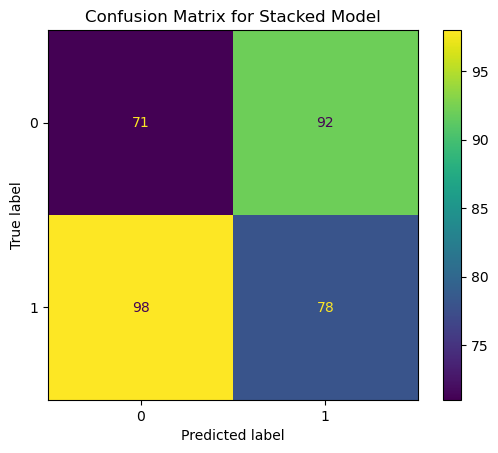

스태킹 모델이 저장되었습니다.


In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sqlite3
import joblib

from sklearn.model_selection import TimeSeriesSplit, GridSearchCV, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.svm import SVC
from sklearn import metrics
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import warnings
warnings.filterwarnings('ignore')

# 데이터베이스 파일 경로
db_file = '../btc_data_day_20170901_20241205.db'

# 데이터베이스 연결
con = sqlite3.connect(db_file)

# SQL 쿼리 실행 및 데이터프레임으로 불러오기
query = "SELECT * FROM ticker_data"
df = pd.read_sql_query(query, con)

# 데이터베이스 연결 종료
con.close()

# 데이터 전처리
df = df.drop_duplicates(keep='first')
df['datetime'] = pd.to_datetime(df['trade_date'] + ' ' + df['trade_time'])
df = df.sort_values(by='datetime')
df.rename(columns={'trade_price':'closing_price'}, inplace=True)

# 필요한 열만 선택
new_column_order = [
    'datetime', 'type', 'code', 'opening_price', 'closing_price', 
    'high_price', 'low_price', 'trade_volume', 'trade_date'
]
df = df[new_column_order] 
df = df[df['trade_date'] != '2017-09-26']
df = df[df['trade_date'] != '2017-09-25']

# 특성 및 타겟 생성
df['year'] = df['datetime'].dt.year
df['month'] = df['datetime'].dt.month
df['day'] = df['datetime'].dt.day
df['open-close']  = df['opening_price'] - df['closing_price']
df['low-high']  = df['low_price'] - df['high_price']
df['target'] = np.where(df['closing_price'].shift(-1) > df['closing_price'], 1, 0)
df['is_quarter_end'] = np.where(df['month'] % 3 == 0, 1, 0)
df.reset_index(drop=True, inplace=True)

# 데이터 분할
df_all = df[df['trade_date'].str[:4] != '2024']
df2024 = df[df['trade_date'].str[:4] == '2024']

features = df_all[['open-close', 'low-high', 'is_quarter_end']]
target = df_all['target']

features_2024 = df2024[['open-close', 'low-high', 'is_quarter_end']]
target_2024 = df2024['target']

# 데이터 스케일링
scaler = StandardScaler()
features = scaler.fit_transform(features)
features_2024 = scaler.transform(features_2024)

# 학습 및 검증 데이터 분할
X_train, X_valid, Y_train, Y_valid = train_test_split(
    features, target, test_size=0.1, random_state=11)

# 랜덤 포레스트 모델 설정
rf_model = RandomForestClassifier(
    bootstrap=True,
    max_depth=40,
    max_features='sqrt',
    min_samples_leaf=4,
    min_samples_split=5,
    n_estimators=50
)

# 서포트 벡터 머신 모델 설정
svc_model = SVC(
    C=100,
    degree=2,
    gamma=0.1,
    kernel='sigmoid',
    probability=True  # 확률 예측을 위해 True로 설정
)

# 스태킹 앙상블 모델 설정
stacked_model = StackingClassifier(
    estimators=[('rf', rf_model), ('svc', svc_model)],
    final_estimator=RandomForestClassifier()  # 최종 추정을 위한 모델
)

# Time Series Split을 사용한 하이퍼파라미터 튜닝
tscv = TimeSeriesSplit(n_splits=3)
grid_search = GridSearchCV(stacked_model, {}, scoring='precision', cv=tscv, n_jobs=-1, verbose=1)
grid_search.fit(X_train, Y_train)

best_stacked_model = grid_search.best_estimator_

print(f"Best Stacked Model: {best_stacked_model}")

# 최종 모델 평가 및 혼동 행렬
print('Training Accuracy : ', metrics.roc_auc_score(Y_train, best_stacked_model.predict_proba(X_train)[:, 1]))
print('Validation Accuracy : ', metrics.roc_auc_score(Y_valid, best_stacked_model.predict_proba(X_valid)[:, 1]))
print('Validation Accuracy (2024): ', metrics.roc_auc_score(target_2024, best_stacked_model.predict_proba(features_2024)[:, 1]))

# 모델 예측 및 혼동 행렬 계산
y_pred = best_stacked_model.predict(features_2024)
cm = confusion_matrix(target_2024, y_pred)

# 혼동 행렬 출력
print("혼동 행렬:")
print(cm)

# 혼동 행렬의 각 값 추출
TP = cm[1, 1]  # True Positive
TN = cm[0, 0]  # True Negative
FP = cm[0, 1]  # False Positive
FN = cm[1, 0]  # False Negative

# 각 값 출력
print(f"True Positive (TP): {TP}")
print(f"True Negative (TN): {TN}")
print(f"False Positive (FP): {FP}")
print(f"False Negative (FN): {FN}")

# 성능 지표 계산
accuracy = metrics.accuracy_score(target_2024, y_pred)
precision = metrics.precision_score(target_2024, y_pred)
recall = metrics.recall_score(target_2024, y_pred)
f1 = metrics.f1_score(target_2024, y_pred)
roc_auc = metrics.roc_auc_score(target_2024, best_stacked_model.predict_proba(features_2024)[:, 1])

# 지표 출력
print(f"정확도 (Accuracy): {accuracy:.4f}")
print(f"정밀도 (Precision): {precision:.4f}")
print(f"재현율 (Recall): {recall:.4f}")
print(f"F1 점수 (F1 Score): {f1:.4f}")
print(f"ROC AUC 점수: {roc_auc:.4f}")

# 혼동 행렬 시각화
ConfusionMatrixDisplay.from_estimator(best_stacked_model, features_2024, target_2024)
plt.title('Confusion Matrix for Stacked Model')
plt.show()

# 모델 저장
joblib.dump(best_stacked_model, 'best_stacked_model.pkl')
print("스태킹 모델이 저장되었습니다.")


혼동 행렬:
[[54 53]
 [50 72]]
정확도 (Accuracy): 0.5502
정밀도 (Precision): 0.5760
재현율 (Recall): 0.5902
F1 점수 (F1 Score): 0.5830
ROC AUC 점수: 0.5533


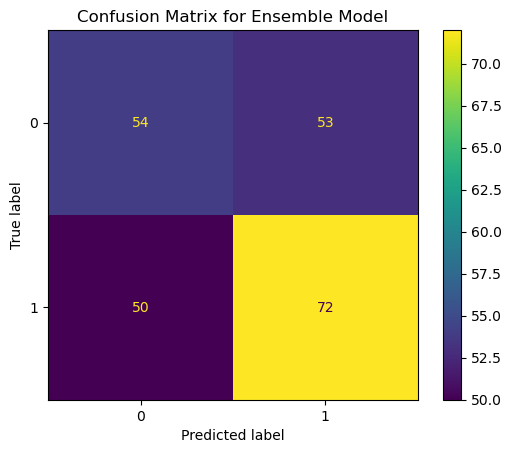

랜덤 포레스트 및 SVM 모델이 저장되었습니다.


In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sqlite3
import joblib

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn import metrics
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import warnings
warnings.filterwarnings('ignore')

# 데이터베이스 파일 경로
db_file = '../btc_data_day_20170901_20241205.db'

# 데이터베이스 연결
con = sqlite3.connect(db_file)

# SQL 쿼리 실행 및 데이터프레임으로 불러오기
query = "SELECT * FROM ticker_data"
df = pd.read_sql_query(query, con)

# 데이터베이스 연결 종료
con.close()

# 데이터 전처리
df = df.drop_duplicates(keep='first')
df['datetime'] = pd.to_datetime(df['trade_date'] + ' ' + df['trade_time'])
df = df.sort_values(by='datetime')
df.rename(columns={'trade_price':'closing_price'}, inplace=True)

# 필요한 열만 선택
new_column_order = [
    'datetime', 'type', 'code', 'opening_price', 'closing_price', 
    'high_price', 'low_price', 'trade_volume', 'trade_date'
]
df = df[new_column_order] 
df = df[df['trade_date'] != '2017-09-26']
df = df[df['trade_date'] != '2017-09-25']

# 특성 및 타겟 생성
df['year'] = df['datetime'].dt.year
df['month'] = df['datetime'].dt.month
df['day'] = df['datetime'].dt.day
df['open-close']  = df['opening_price'] - df['closing_price']
df['low-high']  = df['low_price'] - df['high_price']
df['target'] = np.where(df['closing_price'].shift(-1) > df['closing_price'], 1, 0)
df['is_quarter_end'] = np.where(df['month'] % 3 == 0, 1, 0)
df.reset_index(drop=True, inplace=True)

# 데이터 분할
df_all = df[df['trade_date'].str[:4] != '2024']
df2024 = df[df['trade_date'].str[:4] == '2024']

features = df_all[['open-close', 'low-high', 'is_quarter_end']]
target = df_all['target']

features_2024 = df2024[['open-close', 'low-high', 'is_quarter_end']]
target_2024 = df2024['target']

# 데이터 스케일링
scaler = StandardScaler()
features = scaler.fit_transform(features)
features_2024 = scaler.transform(features_2024)

# 학습 및 검증 데이터 분할
X_train, X_valid, Y_train, Y_valid = train_test_split(
    features, target, test_size=0.1, random_state=11)

# 랜덤 포레스트 모델 설정
rf_model = RandomForestClassifier(
    bootstrap=True,
    max_depth=40,
    max_features='sqrt',
    min_samples_leaf=4,
    min_samples_split=5,
    n_estimators=50
)

# 서포트 벡터 머신 모델 설정
svc_model = SVC(
    C=100,
    degree=2,
    gamma=0.1,
    kernel='sigmoid',
    probability=True  # 확률 예측을 위해 True로 설정
)

# 모델 학습
rf_model.fit(X_train, Y_train)
svc_model.fit(X_train, Y_train)

# 예측 확률 얻기
rf_probs = rf_model.predict_proba(X_valid)[:, 1]
svc_probs = svc_model.predict_proba(X_valid)[:, 1]

# 두 모델의 예측 확률 평균
ensemble_probs = (rf_probs + svc_probs) / 2

# 최종 예측
ensemble_predictions = (ensemble_probs >= 0.5).astype(int)

# 혼동 행렬 계산
cm = confusion_matrix(Y_valid, ensemble_predictions)

# 혼동 행렬 출력
print("혼동 행렬:")
print(cm)

# 성능 지표 계산
accuracy = metrics.accuracy_score(Y_valid, ensemble_predictions)
precision = metrics.precision_score(Y_valid, ensemble_predictions)
recall = metrics.recall_score(Y_valid, ensemble_predictions)
f1 = metrics.f1_score(Y_valid, ensemble_predictions)
roc_auc = metrics.roc_auc_score(Y_valid, ensemble_probs)

# 지표 출력
print(f"정확도 (Accuracy): {accuracy:.4f}")
print(f"정밀도 (Precision): {precision:.4f}")
print(f"재현율 (Recall): {recall:.4f}")
print(f"F1 점수 (F1 Score): {f1:.4f}")
print(f"ROC AUC 점수: {roc_auc:.4f}")

# 혼동 행렬 시각화
ConfusionMatrixDisplay(confusion_matrix=cm).plot()
plt.title('Confusion Matrix for Ensemble Model')
plt.show()

# 모델 저장
joblib.dump(rf_model, 'best_ensemble_random_forest_model.pkl')
joblib.dump(svc_model, 'best_ensemble_svc_model.pkl')
print("랜덤 포레스트 및 SVM 모델이 저장되었습니다.")